# Problem Description

The goal of this project is to run regression analyses on COVID-19 time-series data. Specifically, the goal is to see what type of regression models work the best for individual US states, and to see if the models generated by the states can predict another seperate state with (relatively) little error. 

The dataset used is from the NY Times COVID-19 GitHub Repository (https://github.com/nytimes/covid-19-data). The specific dataset is the United States state-level cumulative COVID-19 cases and deaths. It contains dates (by day), state names, FIPS codes, cumulative number of cases and cumulative number of deaths. 

From the dataset, the number cases per day and the number of deaths per day will be found, as these measures should be more useful here.

The types of regression models that will be used will be ridge regression, LASSO regression and elastic-net regression. The results of ridge, LASSO and elastic-net regressions will be compared to see what kind of regularization work best overall and for each individual state. 

The results (predicitons) of the models that use the unfiltered (but preprocessed) dataset will be compared to the results of the individual state models, individually and added together. 

Once the models have been trained and tuned, then the best type of model will be used to predict the deaths per day values of another state that has not been included in the training.

# Python Packages

The following packages are imported for functions that will be used. 

In [65]:
import numpy as np
import pandas as pd
import seaborn as sn
import copy
import io # for importing data
import time # for timing the trainings
import matplotlib.pyplot as plt # plotting
from google.colab import files # upload files
from sklearn.preprocessing import scale
from mpl_toolkits.mplot3d import Axes3D # 3d plots
from sklearn import linear_model # for regression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score # decision criteria
from sklearn.model_selection import train_test_split # to split into training and testing

# Data Preperation

For this dataset, some preproccessing was needed so that the dataset can be used. The following list describes what was done for preproccessing. This was all done in R.

1. Create date indexes
2. Create state indexes
3. Reorder dataset by state index 
4. Find the number of deaths per day
5. Find the number of cases per day
7. Find the 11 states with the most amount of data
8. Subset the dataset so that it only contains those states
9. Export the dataset

The dataset intially as formatted as below.

In [2]:
# read in data from upload
uploaded = files.upload()
inital_dataset = pd.read_csv(io.BytesIO(uploaded['us-states.csv']))
inital_dataset

Saving us-states.csv to us-states.csv


Unnamed: 0        date          state  ...  c_per_day  d_per_day     id
0               1  2020-01-21     Washington  ...          1          0      1
1               2  2020-01-22     Washington  ...          0          0      2
2               3  2020-01-23     Washington  ...          0          0      3
3               4  2020-01-24       Illinois  ...          1          0      4
4               5  2020-01-24     Washington  ...          0          0      5
...           ...         ...            ...  ...        ...        ...    ...
21239       21240  2021-03-23       Virginia  ...       1265          8  21240
21240       21241  2021-03-23     Washington  ...        563         17  21241
21241       21242  2021-03-23  West Virginia  ...        327          1  21242
21242       21243  2021-03-23      Wisconsin  ...         46          0  21243
21243       21244  2021-03-23        Wyoming  ...         69          2  21244

[21244 rows x 11 columns]

The following R code was used for the preprocessing. First, the inital dataset was loaded, and then the dates were indexed. 

```
# read in initial data
data = read.csv("us-states.csv")

# find the unique dates
dates = unique(data$date)

# initialize the data index column
data$date_index = 0

# assign the date indexes to the proper dates
for(i in 1:nrow(data))
{
  for(j in 1:length(dates))
  {
    if(data$date[i] == dates[j])
    {
      data$date_index[i] = j
    }
  }
}
```

Then, the states are indexed.

```
# find the unique state names as sort them alphabetically
states = unique(data$state)
states = sort(states)

# initialize the state_index column
data$state_index = 0
# assign the state indexes to the appropriate state
for(i in 1:nrow(data))
{
  for(j in 1:length(states))
  {
    if(data$state[i] == states[j])
    {
      data$state_index[i] = j
    }
  }
}
```

Then, each row of the dataset is assigned a unique ID so that the change in the number of cases and the change in the number of deaths can be calculated. Then, additional columns are added to the dataset for those changes. Next, the data was ordered by state index, so that calculating the changes is easier.

```
# assign a unique id to each row
unique_id = seq(1, nrow(data))
data$id = unique_id

# initialize the cases per day and the deaths per day columns
data$c_per_day = 0
data$d_per_day = 0

# order the data by state index
data = data[order(data$state_index),]
```

The changes in cases and deaths are calculated.



```
# calculate the cases per day and the deaths per day
for(i in 1:nrow(data))
{
  if(i == 1) # for the first row, needs an exception
  {
    data$c_per_day[i] = data$cases[i]
    data$d_per_day[i] = data$deaths[i]
  }
  else
  {
    if(data$state_index[i] == data$state_index[i-1]) # if i is still in the same state as i-1
    {
      data$c_per_day[i] = data$cases[i] - data$cases[i-1]
      data$d_per_day[i] = data$deaths[i] - data$deaths[i-1]
    }
    if(data$state_index[i] != data$state_index[i-1]) # if i is not in the same state as i-1
    {
      data$c_per_day[i] = data$cases[i]
      data$d_per_day[i] = data$deaths[i]
    }
  }
}
```



Now, each state is checked to see which states have the most data. First, the number of rows for each dataset is found. Then, the vector that stored that data is ordered in decreasing order.



```
# create a matrix to store which states have the most data
n_states = matrix(nrow = length(states), ncol = 2)

# store the number of rows each state has
for(i in 1:length(states))
{
  temp = subset(data, state_index == i)
  n_states[i,1] = i
  n_states[i,2] = nrow(temp)
}

# reorder by nrow size, largest to smallest
n_states = n_states[order(-n_states[,2]),]
```



Then, the 11 states with the largest amounts of data are found.



```
# initialize vector to store the state indexes of the 11 states with the most data 
# (one extra for testing)
n_largest_list = c(0,0,0,0,0,0,0,0,0,0,0)

# store the indexes of the 11 states with the most data
for(i in 1:11)
{
  n_largest_list[i] = n_states[i]
}
```



Then, the dataset is subsetted using only the 11 states selected. 



```
# subset the state with the largest amount of data
data_new = subset(data, state_index == n_largest_list[1])

# iterate to obtain the data from the other states to form a new data-set
for(i in 2:11)
{
  temp = subset(data, state_index == n_largest_list[i])
  data_new = rbind(data_new, temp)
}
```



Finally, the new dataset's columns are reordered for ease of use in Python, and then the dataset is exported as a .csv file.



```
data_new = data_new[, c(10, 1, 2, 4, 5, 6, 7, 3, 8, 9)]

# export processed data
write.csv(data_new, "us-l11-states.csv")
```



Now that the data has been preprocessed, it is loaded into Python for use.

In [3]:
# read in data from upload
uploaded = files.upload()
DATA = pd.read_csv(io.BytesIO(uploaded['us-l11-states.csv']))

Saving us-l11-states.csv to us-l11-states.csv


The processed data is shown below.

In [4]:
DATA

Unnamed: 0     id        date  ... fips  c_per_day  d_per_day
0              1      1  2020-01-21  ...   53          1          0
1              2      2  2020-01-22  ...   53          0          0
2              3      3  2020-01-23  ...   53          0          0
3              5      5  2020-01-24  ...   53          0          0
4              8      8  2020-01-25  ...   53          0          0
...          ...    ...         ...  ...  ...        ...        ...
4503       20979  20979  2021-03-19  ...   12       5140         53
4504       21034  21034  2021-03-20  ...   12       5105         62
4505       21089  21089  2021-03-21  ...   12       3987         29
4506       21144  21144  2021-03-22  ...   12       2862         37
4507       21199  21199  2021-03-23  ...   12       5302         41

[4508 rows x 11 columns]

The data is then split by the 10 states that will be used for training and tuning, and then the one state that will be used at the end as an independent set for testing the final models.

In [5]:
# split up data into the 10 largest states and into the last test state
state_10 = DATA[DATA.state_index == 10].to_numpy()
data_t10 = DATA[DATA.state_index != 10].to_numpy()

# remove data columns that will not be used (i.e., dates in YYYY/MM/DD format and state names)
data = data_t10[:, 6:11].astype(np.float64)

Each of the 10 states that will be used for training and tuning are plotted below to visualize their structures and differences. 

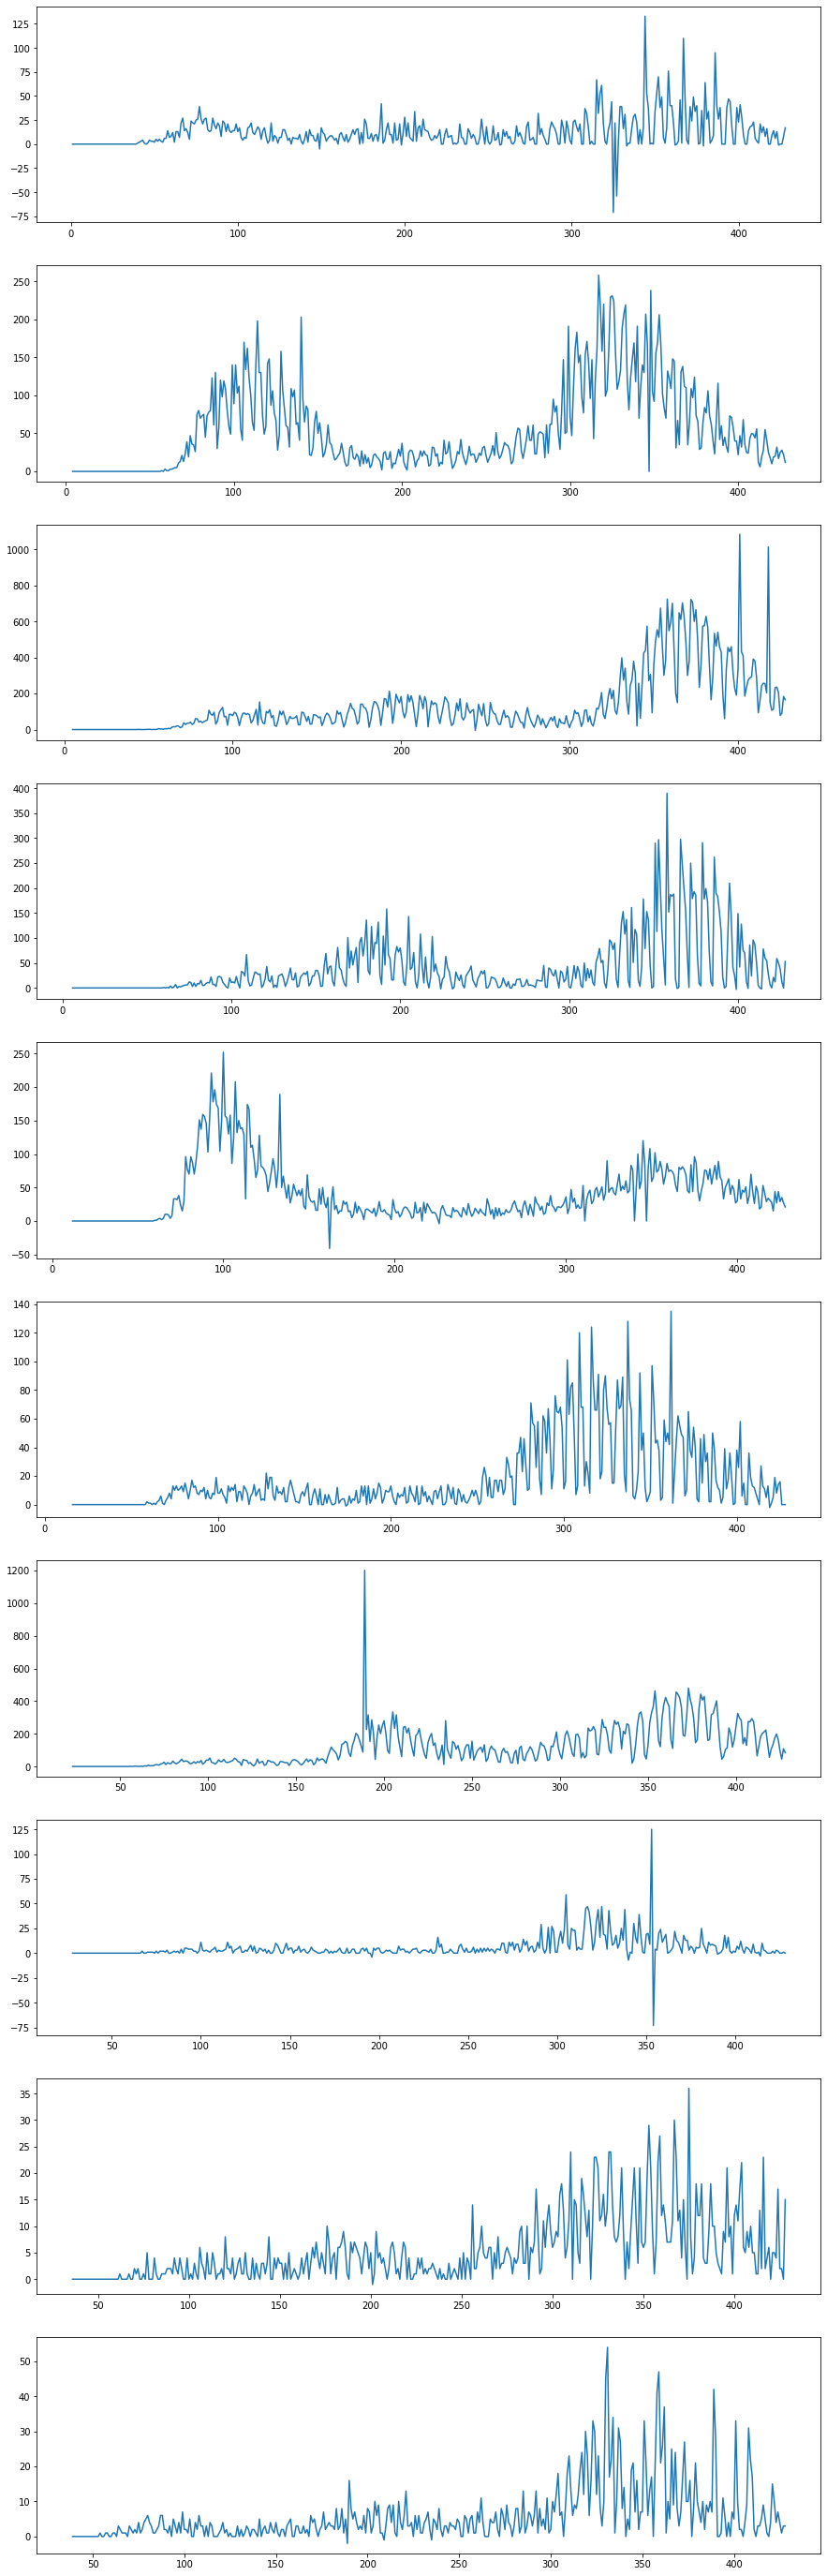

In [125]:
# allow for multiple plots
fig, axes = plt.subplots(nrows = 10, figsize = (15,50))

unique_state_index_list = [52, 15,  5,  3, 23, 54, 47, 29, 48, 40, 10]

unique_state_name_list = ['Washington', 'Illinois', 'California', 'Arizona', 'Massachusetts', 
                          'Wisconsin', 'Texas', 'Nebraska', 'Utah', 'Oregon', 'Florida']

# plot each state
for i in range(10):
  temp = DATA[DATA.state_index == unique_state_index_list[i]].to_numpy()
  axes[i].plot(temp[:,6], temp[:,10])

It can be seen that the states California, Arizona, Wisconsin, Utah and Oregon have similar structure. Washington and Texas also share similar structures, and Illionis and Massachusetts have similar structure. 

It can be seen that Washington, Texas and Nebraska are all states with some extreme outliers when compared to the other states. 

# Inital Analysis

In order to get a baseline understanding, we will run Ordinary least-squares regression (OLS) on the whole dataset and then for the individual states.

MSE-> train : 4299.394, test : 3028.993
MAE-> train : 31.960, test : 28.293
R2-> train : 0.508, test : 0.439
OLS took 0.014816999435424805 seconds


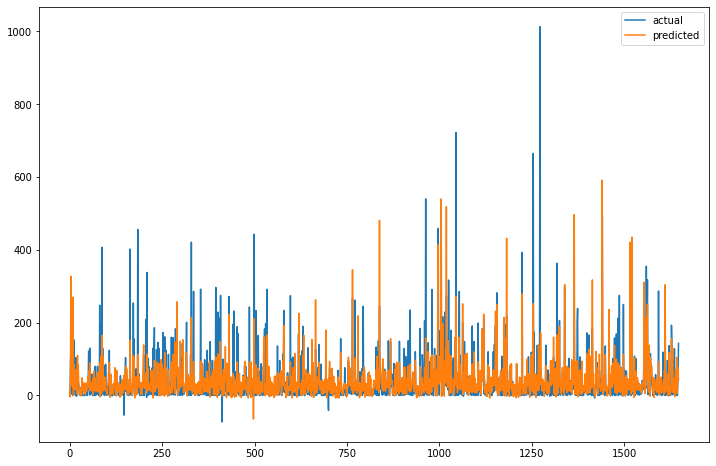

In [42]:
# split data into X and Y components
X_w = data[:, 0:4]
Y_w = data[:, 4]

start = time.time() # time how long it takes to find the model

# split the data into training and testing
(trainX, testX, trainY, testY) = train_test_split(X_w, Y_w, test_size = 0.4, random_state = 0)

# create model
model = linear_model.LinearRegression(normalize = True)

# fit model
model.fit(trainX, trainY)

# test model
trainPred = model.predict(trainX)
testPred = model.predict(testX)
print('MSE-> train : %.3f, test : %.3f' % (mean_squared_error(trainY,trainPred), mean_squared_error(testY,testPred)))
print('MAE-> train : %.3f, test : %.3f' % (mean_absolute_error(trainY,trainPred), mean_absolute_error(testY,testPred)) )
print('R2-> train : %.3f, test : %.3f' % (r2_score(trainY,trainPred), r2_score(testY,testPred)))

end = time.time()
print('OLS took', end - start, 'seconds')

plt.figure(figsize=(12,8))
plt.plot(testY,label="actual")
plt.plot(testPred, label="predicted")
plt.legend()
plt.show()

It can be seen that for the overall data model, the $R^2$ score for the training set is 0.508 and for the testing set is 0.439. Despite that, the mean absolute error (MAE) of the testing set is less than the MAE of the training set.

Now, we will find the OLS models for each of the 10 states to see if the error decreases and/or the $R^2$ score increases.

state index = 52
state = Washington
MSE-> train : 175.622, test : 324.123
MAE-> train : 8.918, test : 10.479
R2-> train : 0.155, test : 0.127
     
state index = 15
state = Illinois
MSE-> train : 1897.751, test : 1336.866
MAE-> train : 33.189, test : 28.212
R2-> train : 0.434, test : 0.478
     
state index = 5
state = California
MSE-> train : 15172.749, test : 14627.429
MAE-> train : 80.405, test : 80.084
R2-> train : 0.467, test : 0.489
     
state index = 3
state = Arizona
MSE-> train : 1878.652, test : 2540.738
MAE-> train : 26.364, test : 31.464
R2-> train : 0.430, test : 0.283
     
state index = 23
state = Massachusetts
MSE-> train : 1385.592, test : 1346.657
MAE-> train : 26.596, test : 26.416
R2-> train : 0.273, test : 0.229
     
state index = 54
state = Wisconsin
MSE-> train : 275.961, test : 249.764
MAE-> train : 10.380, test : 10.817
R2-> train : 0.532, test : 0.572
     
state index = 47
state = Texas
MSE-> train : 10126.549, test : 4713.550
MAE-> train : 56.044, test : 4

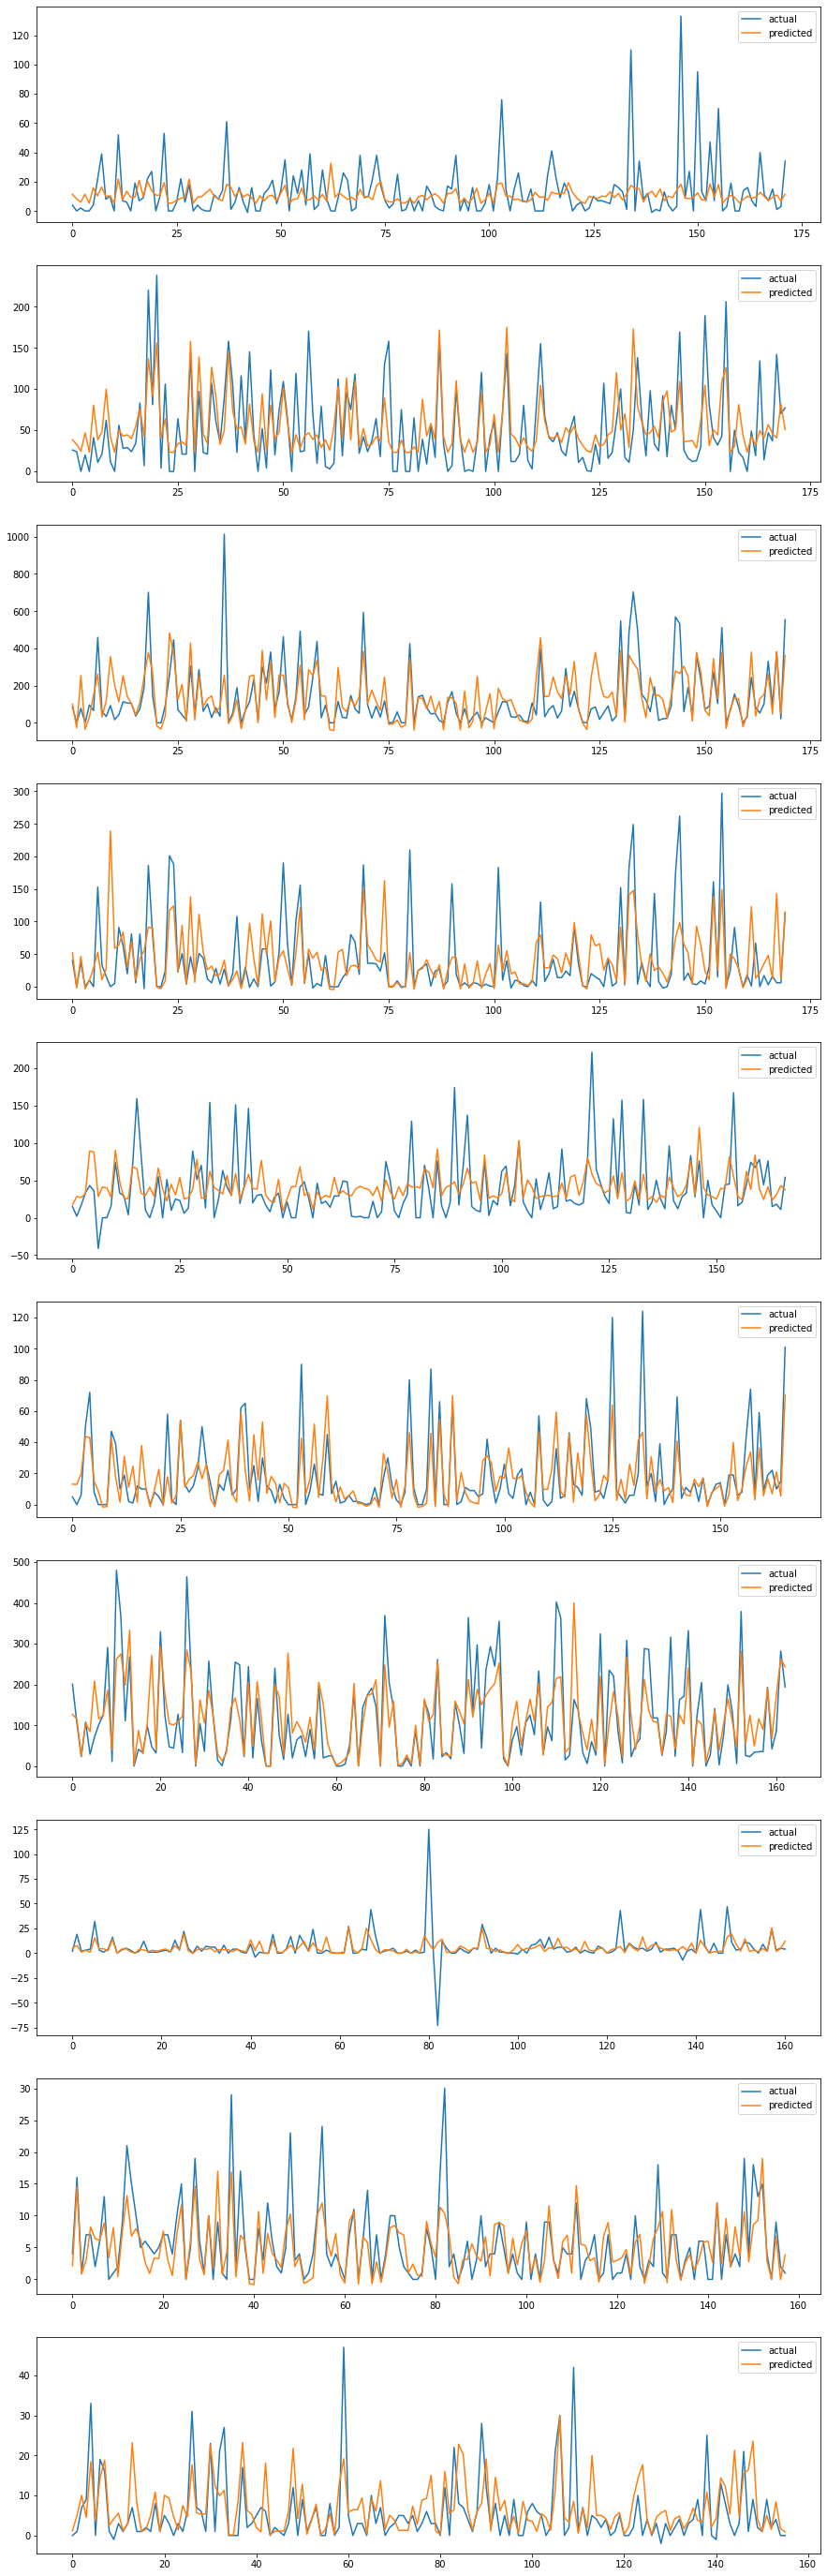

In [119]:
# allow for multiple plots
fig, axes = plt.subplots(nrows = 10, figsize = (15,50))

# run OLS on each state
start_1 = time.time() # time how long it takes to find the models
for i in range(10):
  # create temporary dataset
  temp = DATA[DATA.state_index == unique_state_index_list[i]].to_numpy()

  # split data into X and Y components
  X = temp[:, 6:10]
  Y = temp[:, 10]

  # split the data into training and testing
  (trainX, testX, trainY, testY) = train_test_split(X, Y, test_size = 0.4, random_state = 0)

  # create model
  model = linear_model.LinearRegression(normalize = True)

  # fit model
  model.fit(trainX, trainY)

  # test model
  trainPred = model.predict(trainX)
  testPred = model.predict(testX)
  print('state index =', unique_state_index_list[i])
  print('state =', unique_state_name_list[i])
  print('MSE-> train : %.3f, test : %.3f' % (mean_squared_error(trainY,trainPred), mean_squared_error(testY,testPred)))
  print('MAE-> train : %.3f, test : %.3f' % (mean_absolute_error(trainY,trainPred), mean_absolute_error(testY,testPred)) )
  print('R2-> train : %.3f, test : %.3f' % (r2_score(trainY,trainPred), r2_score(testY,testPred)))
  print('     ')

  # plot model
  axes[i].plot(testY,label="actual")
  axes[i].plot(testPred, label="predicted")
  axes[i].legend()

end_1 = time.time()
print('Finding all of the OLS models took', end_1 - start_1, 'seconds')

It can be seen that for several of the states, such as Wisconsin, Texas, and Utah, finding the OLS for those indivdual improves the error and the predictions. However, it can also be seen that this has the opposite effect on Washington, Arizona, and Massachusetts. This is because the data for those states have similar structure, where there are some distinct outliers. 

# More Regression Methods

Now, we will try to use other regression methods to see what effect they have on the errors and the predicitons of the overall dataset and of the individual state data.

The first model that will be used is ridge regression. 

The loss function (below) differes from the linear regression model by the addition of an $L^2$ regularization penalty. 

$$L(\theta) = \|\theta_0 + X\theta - y\| + \lambda_2\|\theta\|^2$$

First, we run ridge regression on the overall dataset. We set the hyperparameter here to 0.01, so that the effect of the regularization does not mute any of the parameters that are important.

Ridge took 0.009790658950805664 seconds
MSE-> train : 4310.298, test : 3030.290
MAE-> train : 32.252, test : 28.476
R2-> train : 0.506, test : 0.439


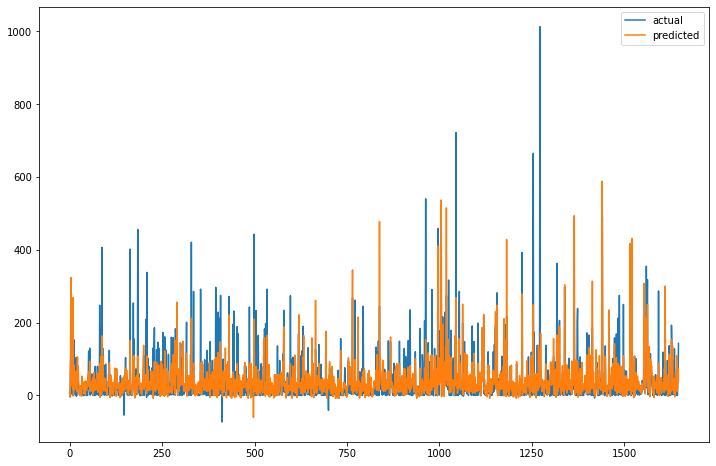

In [126]:
start_2_r = time.time() # time how long it takes to find the model

# split the data into training and testing
(trainX, testX, trainY, testY) = train_test_split(X_w, Y_w, test_size = 0.4, random_state = 0)

# create model
model_r = linear_model.Ridge(alpha = 0.01, normalize = True)

# fit model
model_r.fit(trainX, trainY)

end_2_r = time.time()
print('Ridge took', end_2_r - start_2_r, 'seconds')

# test model
trainPred2 = model_r.predict(trainX)
testPred2 = model_r.predict(testX)
print('MSE-> train : %.3f, test : %.3f' % (mean_squared_error(trainY,trainPred2), mean_squared_error(testY,testPred2)))
print('MAE-> train : %.3f, test : %.3f' % (mean_absolute_error(trainY,trainPred2), mean_absolute_error(testY,testPred2)) )
print('R2-> train : %.3f, test : %.3f' % (r2_score(trainY,trainPred2), r2_score(testY,testPred2)))

plt.figure(figsize=(12,8))
plt.plot(testY,label="actual")
plt.plot(testPred2, label="predicted")
plt.legend()
plt.show()

It can be seen that the results of using ridge regression here are very close to that of OLS, with small differences in testing mean squared error (MAE) and training $R^2$.

We now find the ridge regression models for each of the individual states.

state index = 52
state = Washington
MSE-> train : 175.622, test : 324.146
MAE-> train : 8.919, test : 10.480
R2-> train : 0.155, test : 0.127
     
state index = 15
state = Illinois
MSE-> train : 1897.753, test : 1336.970
MAE-> train : 33.195, test : 28.215
R2-> train : 0.434, test : 0.477
     
state index = 5
state = California
MSE-> train : 15172.756, test : 14625.891
MAE-> train : 80.371, test : 80.051
R2-> train : 0.467, test : 0.489
     
state index = 3
state = Arizona
MSE-> train : 1878.653, test : 2540.114
MAE-> train : 26.362, test : 31.463
R2-> train : 0.430, test : 0.284
     
state index = 23
state = Massachusetts
MSE-> train : 1385.594, test : 1346.748
MAE-> train : 26.592, test : 26.417
R2-> train : 0.273, test : 0.229
     
state index = 54
state = Wisconsin
MSE-> train : 275.961, test : 249.797
MAE-> train : 10.380, test : 10.817
R2-> train : 0.532, test : 0.572
     
state index = 47
state = Texas
MSE-> train : 10126.552, test : 4714.345
MAE-> train : 56.055, test : 4

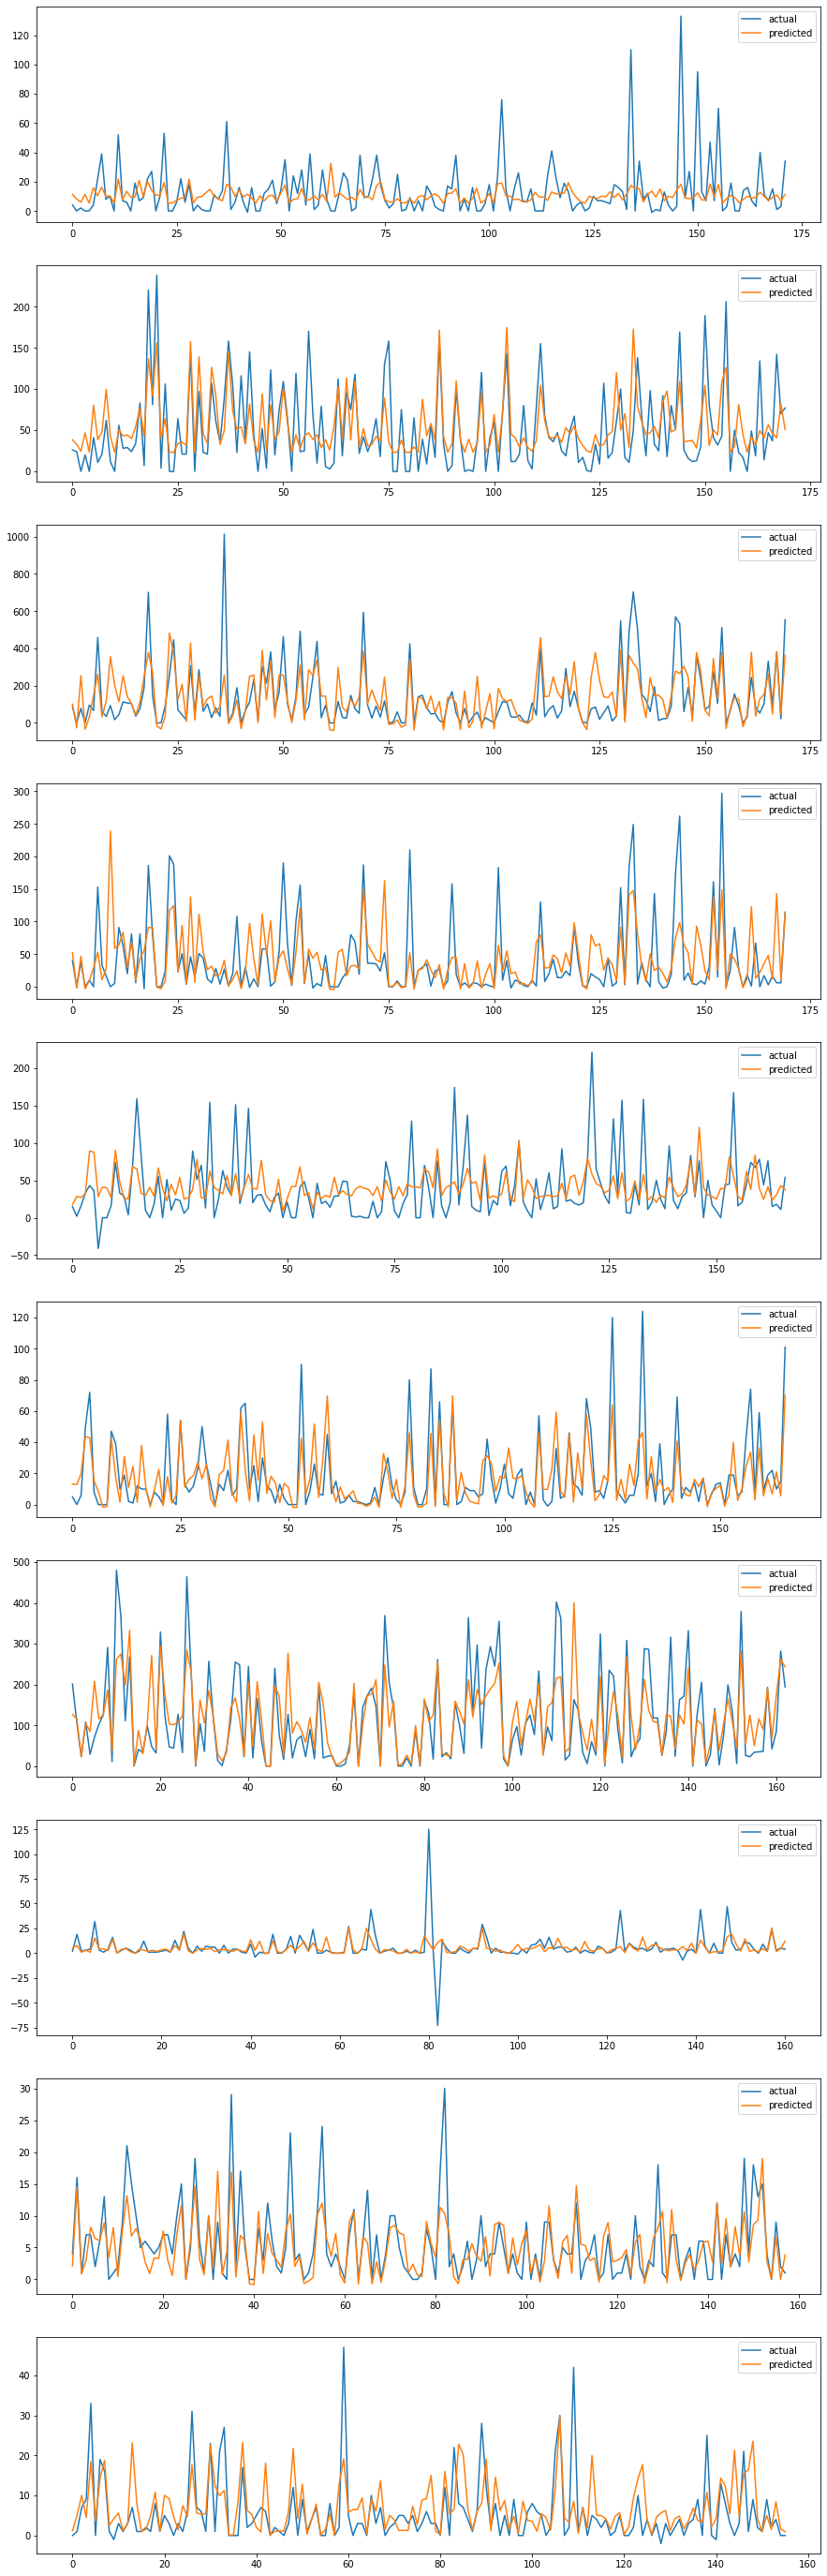

In [44]:
# allow for multiple plots
fig, axes = plt.subplots(nrows = 10, figsize = (15,50))

# run ridge regression on each state
start_2_i = time.time() # time how long it takes to find the models
for i in range(10):
  # create temporary dataset
  temp = DATA[DATA.state_index == unique_state_index_list[i]].to_numpy()

  # split data into X and Y components
  X = temp[:, 6:10]
  Y = temp[:, 10]

  # split the data into training and testing
  (trainX, testX, trainY, testY) = train_test_split(X, Y, test_size = 0.4, random_state = 0)

  # create model
  model_r_i = linear_model.Ridge(alpha = 0.001, normalize = True)

  # fit model
  model_r_i.fit(trainX, trainY)

  # test model
  trainPred = model_r_i.predict(trainX)
  testPred = model_r_i.predict(testX)
  print('state index =', unique_state_index_list[i])
  print('state =', unique_state_name_list[i])
  print('MSE-> train : %.3f, test : %.3f' % (mean_squared_error(trainY,trainPred), mean_squared_error(testY,testPred)))
  print('MAE-> train : %.3f, test : %.3f' % (mean_absolute_error(trainY,trainPred), mean_absolute_error(testY,testPred)) )
  print('R2-> train : %.3f, test : %.3f' % (r2_score(trainY,trainPred), r2_score(testY,testPred)))
  print('     ')

  # plot model
  axes[i].plot(testY,label="actual")
  axes[i].plot(testPred, label="predicted")
  axes[i].legend()

end_2_i = time.time()
print('Finding all of the Ridge models took', end_2_i - start_2_i, 'seconds')

It can be seen for these results, the values are similar to that of OLS.

The next regression model that will be used is LASSO regression.

The loss function (below) differes from the linear regression model and the ridge regression model by the addition of an $L^1$ regularization penalty, instead of an $L^2$ penalty. 

$$L(\theta) = \|\theta_0 + X\theta - y\| + \lambda_1\|\theta\|$$

We run LASSO regression on the overall dataset initally. We set the hyperparameter here to 0.01, so that the effect of the regularization does not remove any parameters when they should not be removed.

LASSO took 0.007058620452880859 seconds
MSE-> train : 4309.814, test : 3036.004
MAE-> train : 32.142, test : 28.393
R2-> train : 0.506, test : 0.438


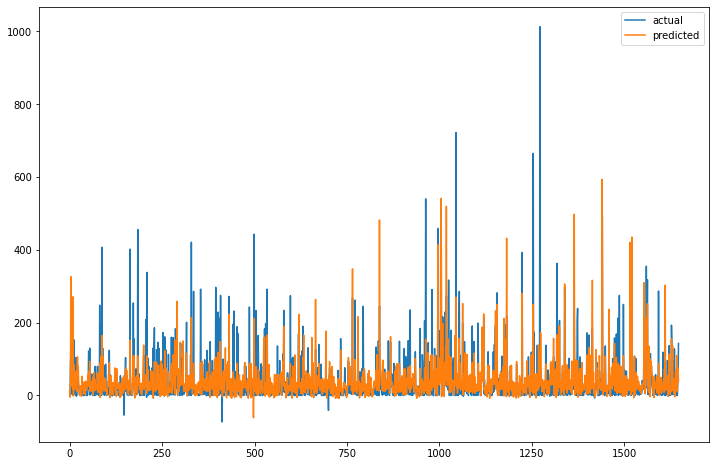

In [21]:
start_2_l = time.time() # time how long it takes to find the model

# split the data into training and testing
(trainX, testX, trainY, testY) = train_test_split(X_w, Y_w, test_size = 0.4, random_state = 0)

# create model
model_l = linear_model.Lasso(alpha = 0.001, normalize = True)

# fit model
model_l.fit(trainX, trainY)

end_2_l = time.time()
print('LASSO took', end_2_l - start_2_l, 'seconds')

# test model
trainPred2 = model_l.predict(trainX)
testPred2 = model_l.predict(testX)
print('MSE-> train : %.3f, test : %.3f' % (mean_squared_error(trainY,trainPred2), mean_squared_error(testY,testPred2)))
print('MAE-> train : %.3f, test : %.3f' % (mean_absolute_error(trainY,trainPred2), mean_absolute_error(testY,testPred2)) )
print('R2-> train : %.3f, test : %.3f' % (r2_score(trainY,trainPred2), r2_score(testY,testPred2)))

plt.figure(figsize=(12,8))
plt.plot(testY,label="actual")
plt.plot(testPred2, label="predicted")
plt.legend()
plt.show()

The results of the LASSO regression has similar results to ridge regression.

We now run LASSO regression on each of the individual states. We keep the hyperparameter as the same as before.

state index = 52
state = Washington
MSE-> train : 175.622, test : 324.230
MAE-> train : 8.920, test : 10.482
R2-> train : 0.155, test : 0.127
     
state index = 15
state = Illinois
MSE-> train : 1897.752, test : 1336.894
MAE-> train : 33.190, test : 28.211
R2-> train : 0.434, test : 0.478
     
state index = 5
state = California
MSE-> train : 15172.749, test : 14627.055
MAE-> train : 80.398, test : 80.078
R2-> train : 0.467, test : 0.489
     
state index = 3
state = Arizona
MSE-> train : 1878.653, test : 2540.422
MAE-> train : 26.361, test : 31.461
R2-> train : 0.430, test : 0.284
     
state index = 23
state = Massachusetts
MSE-> train : 1385.593, test : 1346.708
MAE-> train : 26.592, test : 26.416
R2-> train : 0.273, test : 0.229
     
state index = 54
state = Wisconsin
MSE-> train : 275.961, test : 249.793
MAE-> train : 10.375, test : 10.813
R2-> train : 0.532, test : 0.572
     
state index = 47
state = Texas
MSE-> train : 10126.549, test : 4713.818
MAE-> train : 56.047, test : 4

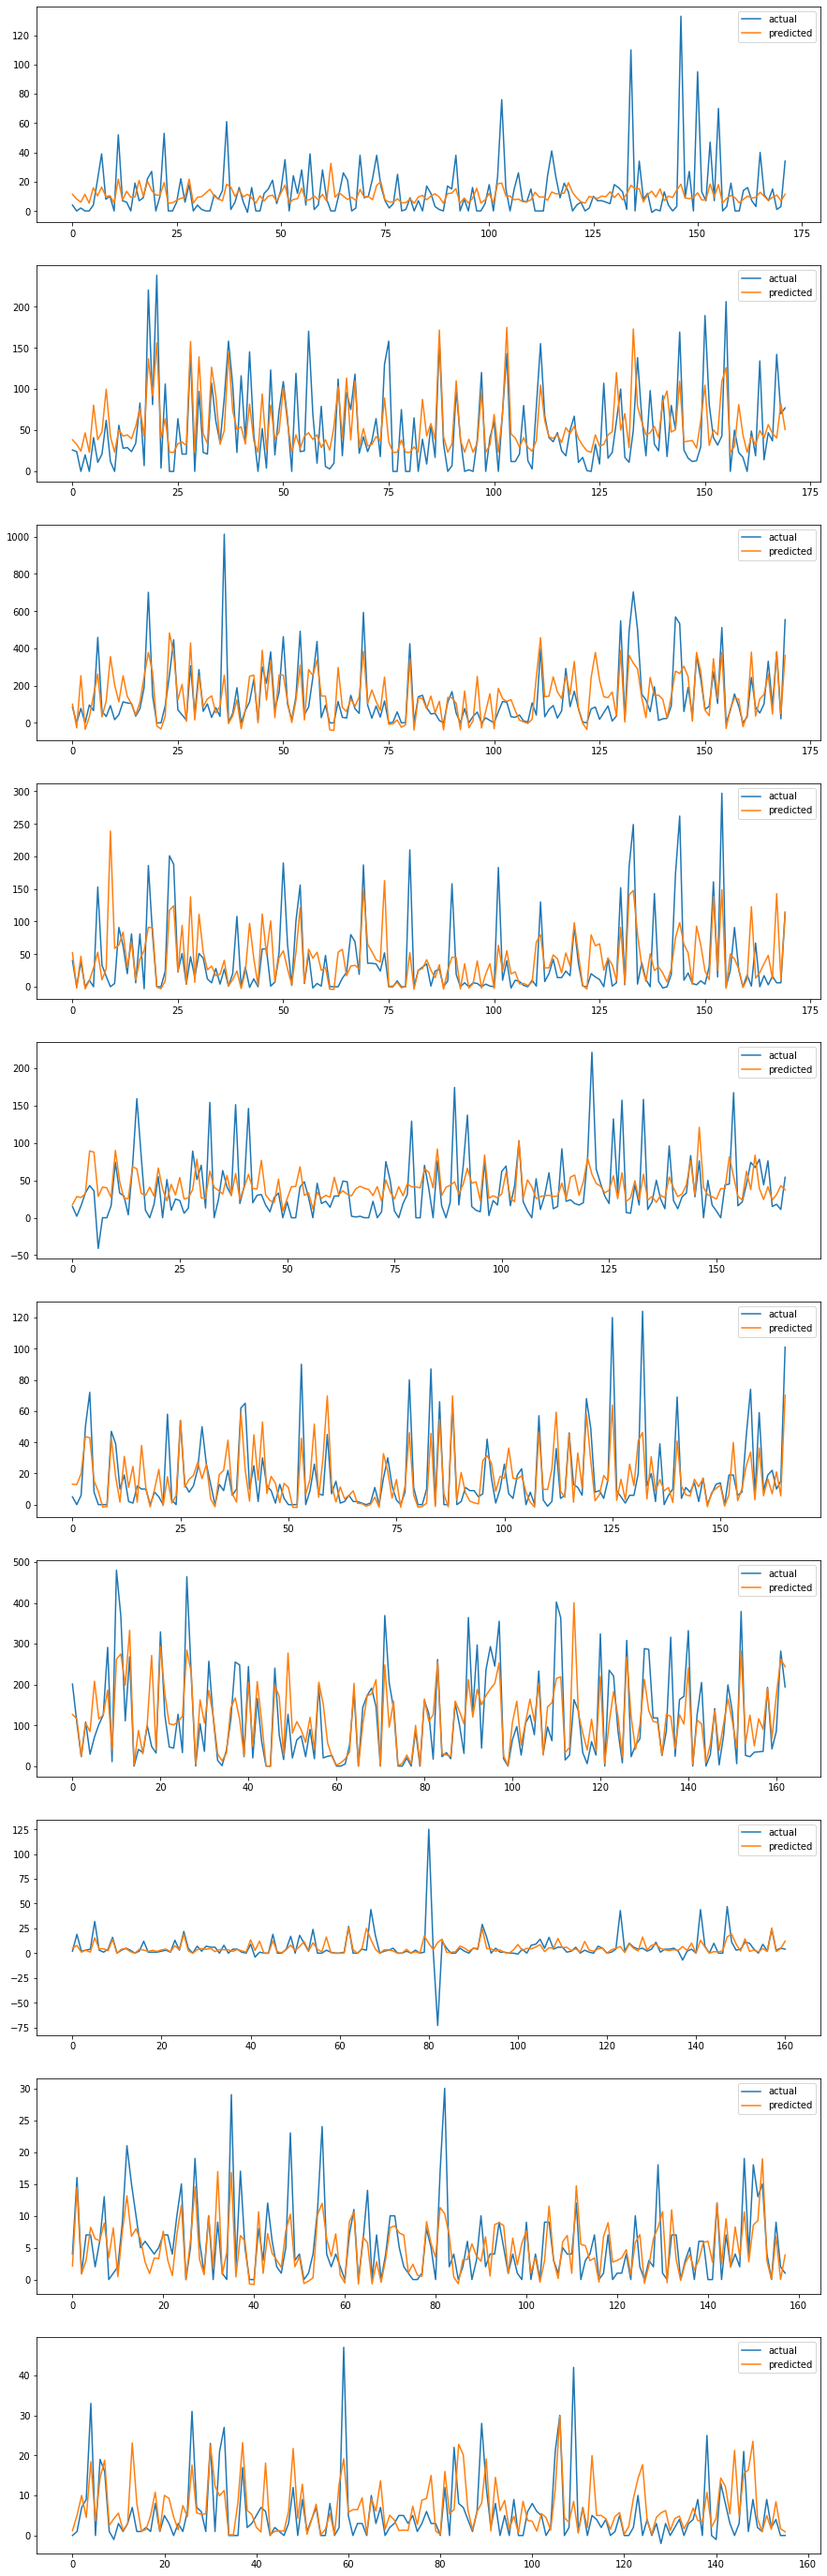

In [45]:
# allow for multiple plots
fig, axes = plt.subplots(nrows = 10, figsize = (15,50))

# run ridge regression on each state
start_2_i = time.time() # time how long it takes to find the models
for i in range(10):
  # create temporary dataset
  temp = DATA[DATA.state_index == unique_state_index_list[i]].to_numpy()

  # split data into X and Y components
  X = temp[:, 6:10]
  Y = temp[:, 10]

  # split the data into training and testing
  (trainX, testX, trainY, testY) = train_test_split(X, Y, test_size = 0.4, random_state = 0)

  # create model
  model_l_i = linear_model.Lasso(alpha = 0.001, normalize = True)

  # fit model
  model_l_i.fit(trainX, trainY)

  # test model
  trainPred = model_l_i.predict(trainX)
  testPred = model_l_i.predict(testX)
  print('state index =', unique_state_index_list[i])
  print('state =', unique_state_name_list[i])
  print('MSE-> train : %.3f, test : %.3f' % (mean_squared_error(trainY,trainPred), mean_squared_error(testY,testPred)))
  print('MAE-> train : %.3f, test : %.3f' % (mean_absolute_error(trainY,trainPred), mean_absolute_error(testY,testPred)) )
  print('R2-> train : %.3f, test : %.3f' % (r2_score(trainY,trainPred), r2_score(testY,testPred)))
  print('     ')

  # plot model
  axes[i].plot(testY,label="actual")
  axes[i].plot(testPred, label="predicted")
  axes[i].legend()

end_2_i = time.time()
print('Finding all of the LASSO models took', end_2_i - start_2_i, 'seconds')

The results of the LASSO regression has similar results to ridge regression.

The final regression model that will be used is elastic-net regression.

The loss function (below) has both $L^1$ and $L^2$ regularization penalties. 

$$L(\theta) = \|\theta_0 + X\theta - y\| + + \lambda_2\|\theta\|^2 + \lambda_1\|\theta\|$$

First, we use elastic-net regression on the overall dataset.

Elastic-net took 0.008738994598388672 seconds
MSE-> train : 4356.687, test : 2996.666
MAE-> train : 33.369, test : 29.324
R2-> train : 0.501, test : 0.445


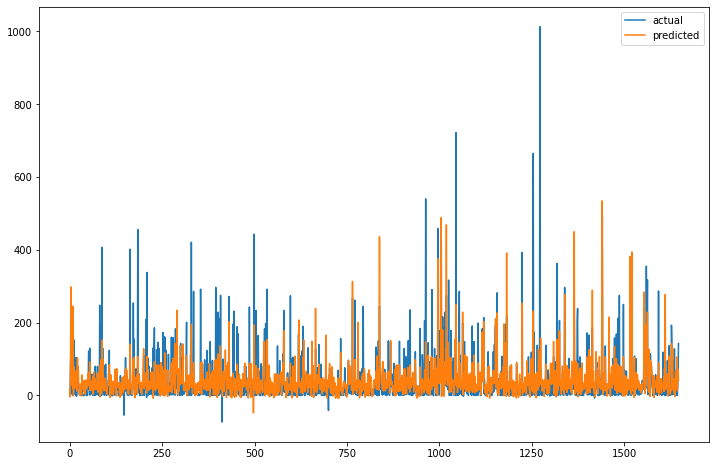

In [22]:
start_2 = time.time() # time how long it takes to find the model

# split the data into training and testing
(trainX, testX, trainY, testY) = train_test_split(X_w, Y_w, test_size = 0.4, random_state = 0)

# create model
model2 = linear_model.ElasticNet(alpha = 0.0001, l1_ratio = 0.5, normalize = True)

# fit model
model2.fit(trainX, trainY)

end_2 = time.time()
print('Elastic-net took', end_2 - start_2, 'seconds')

# test model
trainPred2 = model2.predict(trainX)
testPred2 = model2.predict(testX)
print('MSE-> train : %.3f, test : %.3f' % (mean_squared_error(trainY,trainPred2), mean_squared_error(testY,testPred2)))
print('MAE-> train : %.3f, test : %.3f' % (mean_absolute_error(trainY,trainPred2), mean_absolute_error(testY,testPred2)) )
print('R2-> train : %.3f, test : %.3f' % (r2_score(trainY,trainPred2), r2_score(testY,testPred2)))

plt.figure(figsize=(12,8))
plt.plot(testY,label="actual")
plt.plot(testPred2, label="predicted")
plt.legend()
plt.show()

The results for the elastic-net regression are more different than the results of all of the previously used models. There is better testing values of $R^2$ here, but a slightly larger amount of MAE.

Now, find the models for each of the states.

state index = 52
state = Washington
MSE-> train : 175.626, test : 324.415
MAE-> train : 8.927, test : 10.491
R2-> train : 0.155, test : 0.127
     
state index = 15
state = Illinois
MSE-> train : 1898.068, test : 1338.381
MAE-> train : 33.267, test : 28.252
R2-> train : 0.434, test : 0.477
     
state index = 5
state = California
MSE-> train : 15173.831, test : 14609.076
MAE-> train : 79.973, test : 79.667
R2-> train : 0.467, test : 0.490
     
state index = 3
state = Arizona
MSE-> train : 1878.795, test : 2533.089
MAE-> train : 26.344, test : 31.452
R2-> train : 0.430, test : 0.286
     
state index = 23
state = Massachusetts
MSE-> train : 1385.835, test : 1347.935
MAE-> train : 26.549, test : 26.425
R2-> train : 0.273, test : 0.229
     
state index = 54
state = Wisconsin
MSE-> train : 276.000, test : 250.195
MAE-> train : 10.382, test : 10.810
R2-> train : 0.532, test : 0.572
     
state index = 47
state = Texas
MSE-> train : 10126.938, test : 4723.520
MAE-> train : 56.181, test : 4

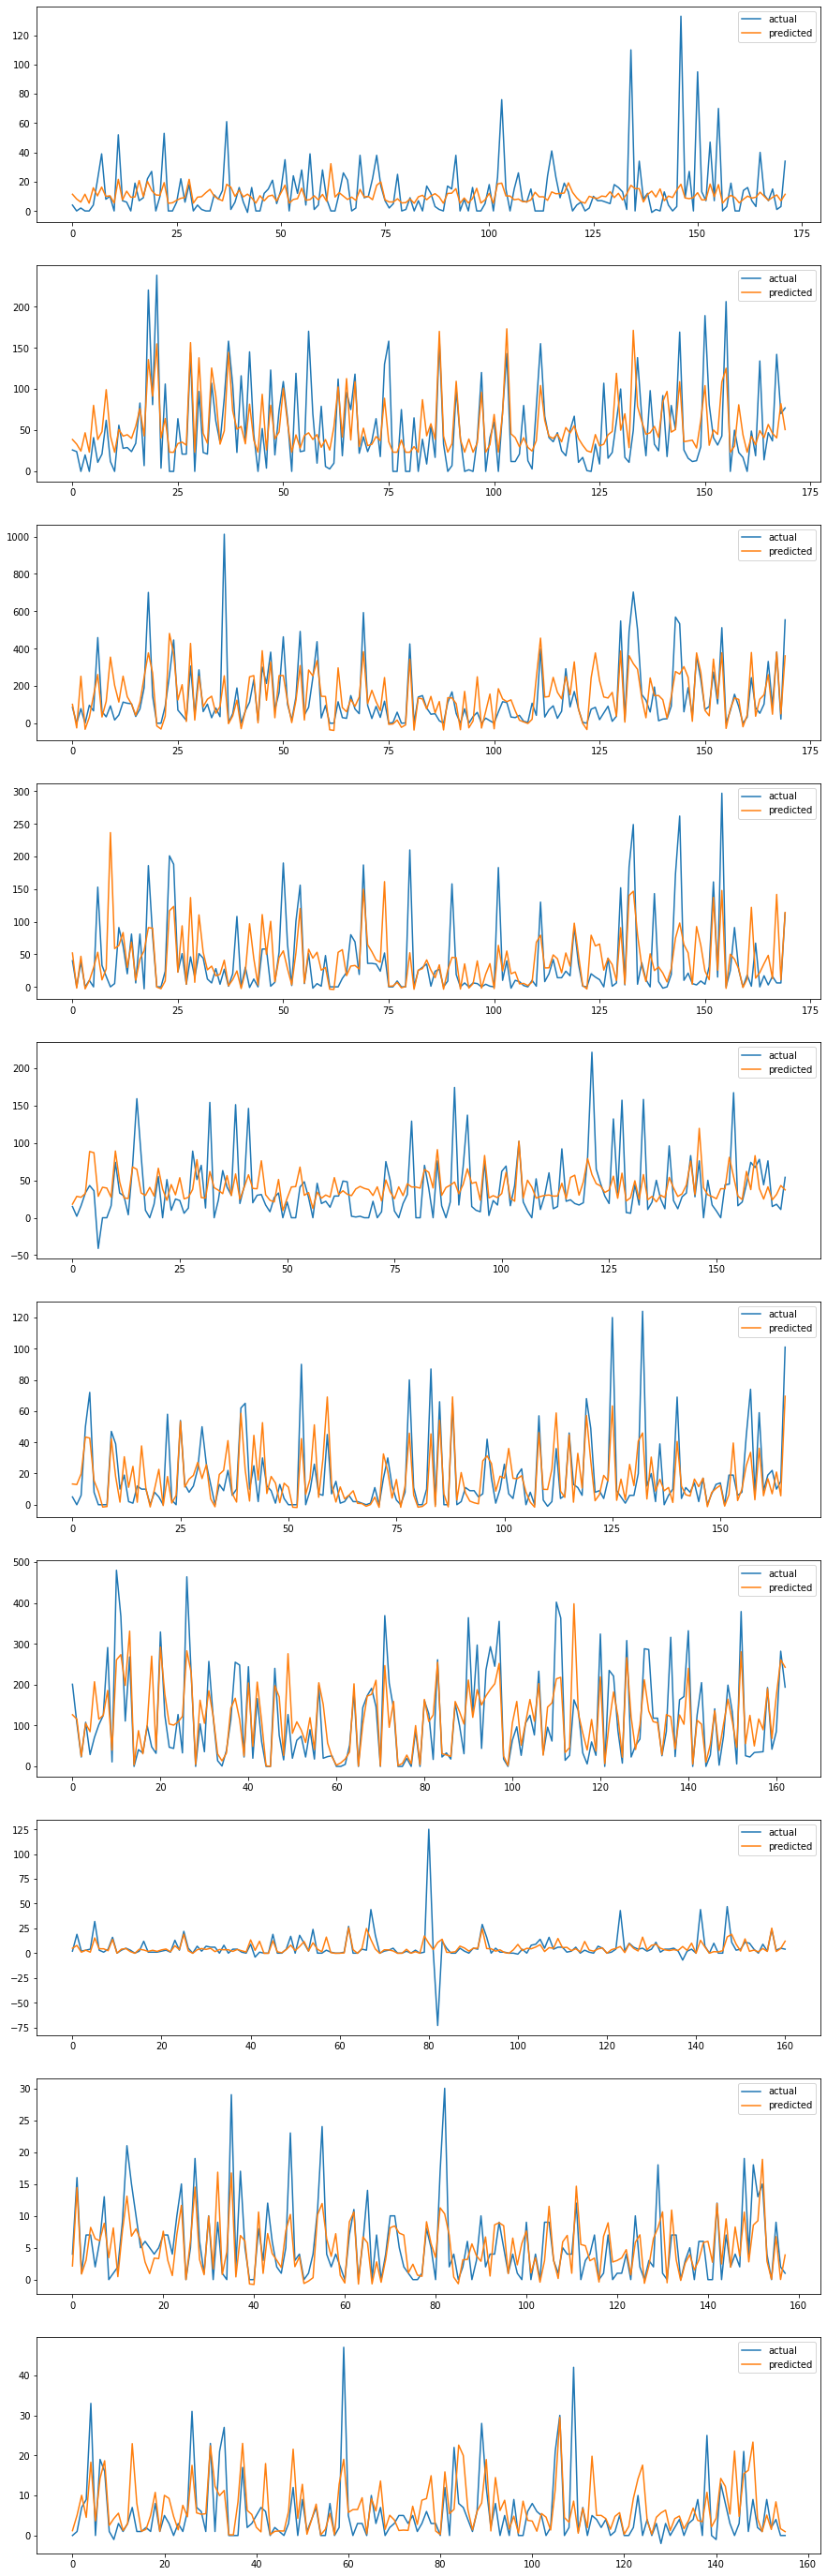

In [46]:
# allow for multiple plots
fig, axes = plt.subplots(nrows = 10, figsize = (15,50))

# run OLS on each state
start_2 = time.time() # time how long it takes to find the models
for i in range(10):
  # create temporary dataset
  temp = DATA[DATA.state_index == unique_state_index_list[i]].to_numpy()

  # split data into X and Y components
  X = temp[:, 6:10]
  Y = temp[:, 10]

  # split the data into training and testing
  (trainX, testX, trainY, testY) = train_test_split(X, Y, test_size = 0.4, random_state = 0)

  # create model
  model2i = linear_model.ElasticNet(alpha = 0.0001, l1_ratio = 0.5, normalize = True)

  # fit model
  model2i.fit(trainX, trainY)

  # test model
  trainPred = model2i.predict(trainX)
  testPred = model2i.predict(testX)
  print('state index =', unique_state_index_list[i])
  print('state =', unique_state_name_list[i])
  print('MSE-> train : %.3f, test : %.3f' % (mean_squared_error(trainY,trainPred), mean_squared_error(testY,testPred)))
  print('MAE-> train : %.3f, test : %.3f' % (mean_absolute_error(trainY,trainPred), mean_absolute_error(testY,testPred)) )
  print('R2-> train : %.3f, test : %.3f' % (r2_score(trainY,trainPred), r2_score(testY,testPred)))
  print('     ')

  # plot model
  axes[i].plot(testY,label="actual")
  axes[i].plot(testPred, label="predicted")
  axes[i].legend()

end_2 = time.time()
print('Finding all of the elastic-net models took', end_2 - start_2, 'seconds')

It can be seen that the results here for elastic-net regression are close to the previous results of the other models. 

# Hyperparameter Tuning

Now that the models have been run intially, we will now tune the hyperparameters of each of the models. The goal of tuning is to find the values of the hyperparameters that give the best values for the error and predicitions. 

The first model we will tune is the ridge regression, where we will tune the $\alpha$ parameter. We tune the hyperparameters of the model first using the overall dataset.

alpha =  0.005
MSE-> train : 4309.490, test : 3032.890
MAE-> train : 32.192, test : 28.431
R2-> train : 0.507, test : 0.438
     
alpha =  0.005263157894736842
MSE-> train : 4309.551, test : 3032.769
MAE-> train : 32.195, test : 28.434
R2-> train : 0.507, test : 0.438
     
alpha =  0.005526315789473685
MSE-> train : 4309.607, test : 3032.644
MAE-> train : 32.198, test : 28.436
R2-> train : 0.507, test : 0.438
     
alpha =  0.005789473684210527
MSE-> train : 4309.661, test : 3032.517
MAE-> train : 32.202, test : 28.439
R2-> train : 0.507, test : 0.438
     
alpha =  0.0060526315789473685
MSE-> train : 4309.711, test : 3032.387
MAE-> train : 32.205, test : 28.441
R2-> train : 0.506, test : 0.438
     
alpha =  0.00631578947368421
MSE-> train : 4309.759, test : 3032.255
MAE-> train : 32.208, test : 28.444
R2-> train : 0.506, test : 0.438
     
alpha =  0.006578947368421052
MSE-> train : 4309.805, test : 3032.122
MAE-> train : 32.212, test : 28.446
R2-> train : 0.506, test : 0.438
     


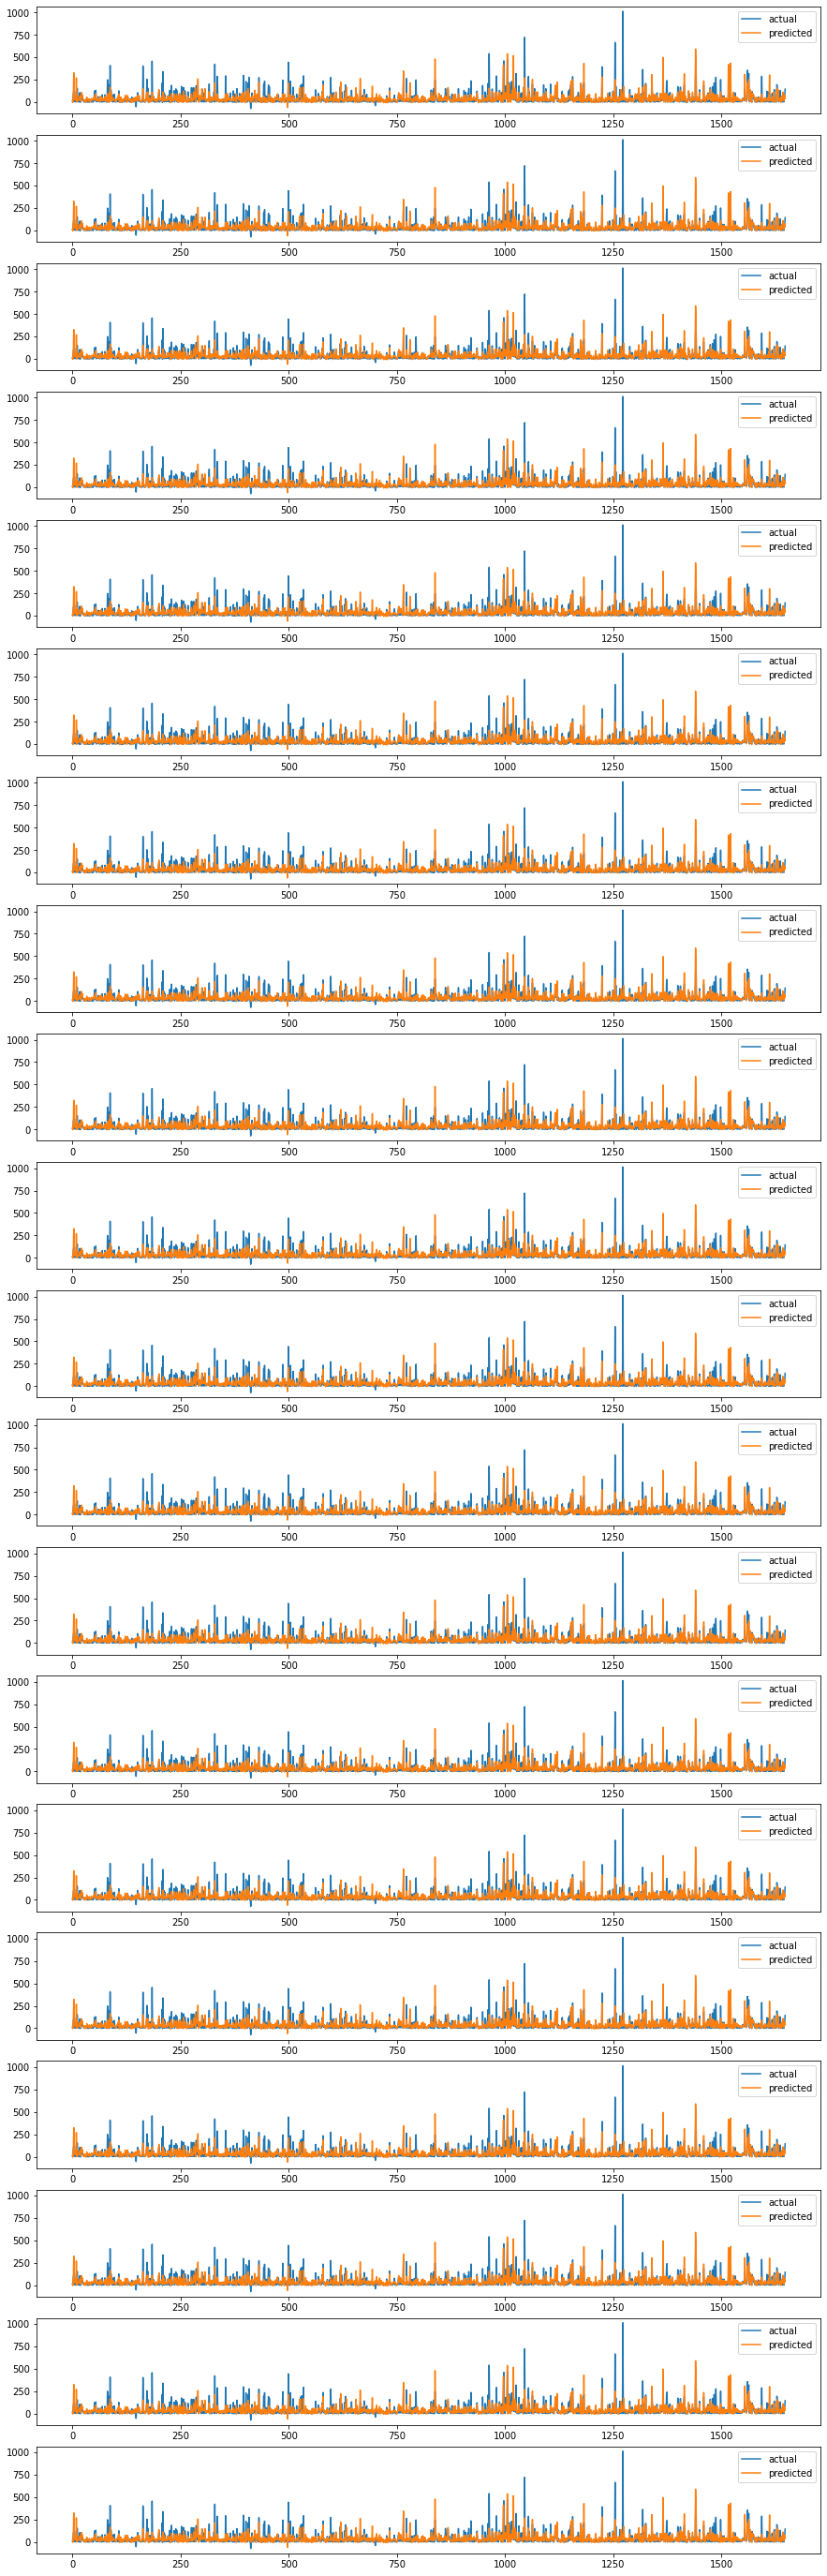

In [129]:
alphaValues = np.linspace(0.005, 0.01, 20)

start_r_t = time.time() # time how long it takes to find the model

# split the data into training and testing
(trainX, testX, trainY, testY) = train_test_split(X_w, Y_w, test_size = 0.4, random_state = 0)

trainMAE = []
testMAE = []

# allow multiple plots
fig, axes = plt.subplots(nrows = 20, figsize = (15,50))

for i in range(20):
  # create model
  model2i = linear_model.Ridge(alpha = alphaValues[i], normalize = True)

  # fit model
  model2i.fit(trainX, trainY)

  # test model
  trainPred = model2i.predict(trainX)
  testPred = model2i.predict(testX)
  trainMAE.append(mean_absolute_error(trainY,trainPred))
  testMAE.append(mean_absolute_error(testY,testPred))
  print("alpha = ", alphaValues[i])
  print('MSE-> train : %.3f, test : %.3f' % (mean_squared_error(trainY,trainPred), mean_squared_error(testY,testPred)))
  print('MAE-> train : %.3f, test : %.3f' % (mean_absolute_error(trainY,trainPred), mean_absolute_error(testY,testPred)))
  print('R2-> train : %.3f, test : %.3f' % (r2_score(trainY,trainPred), r2_score(testY,testPred)))
  print('     ')

  # plot model
  axes[i].plot(testY,label="actual")
  axes[i].plot(testPred, label="predicted")
  axes[i].legend()

end_r_t = time.time()
print('Tuning the ridge models took', end_r_t - start_r_t, 'seconds')

Now, we will find the optimal $\alpha$ value from above.

In [134]:
min_train = 999
alpha_train = 0
min_test = 999
alpha_test = 0

for i in range(20):
  if min_train > trainMAE[i]:
    min_train = trainMAE[i]
    alpha_train = alphaValues[i]
  if min_test > testMAE[i]:
    min_test = testMAE[i]
    alpha_test = alphaValues[i]

print('training alpha:', alpha_train)
print('testing alpha:', alpha_test)

training alpha: 0.005
testing alpha: 0.005


We find that the optimal value of $\alpha$ for both the training and testing predicitions is 0.005. 

Now, we will tune the hyperparameter of the model with the individual models.

In [148]:
alphaValues = np.linspace(0.005, 0.01, 20)

trainMAE = []
testMAE = []

# iterate for each state
for i in range(10):
  start_r_t = time.time() # time how long it takes to find the model
  # create temporary dataset
  temp = DATA[DATA.state_index == unique_state_index_list[i]].to_numpy()

  # split data into X and Y components
  X = temp[:, 6:10]
  Y = temp[:, 10]

  # split the data into training and testing
  (trainX, testX, trainY, testY) = train_test_split(X, Y, test_size = 0.4, random_state = 0)

  min_train = 999
  alpha_train = 0
  min_test = 999
  alpha_test = 0

  print('State:', unique_state_name_list[i])

  for j in range(20):
    # create model
    model2j = linear_model.Ridge(alpha = alphaValues[j], normalize = True)

    # fit model
    model2j.fit(trainX, trainY)

    # test model
    trainPred = model2j.predict(trainX)
    testPred = model2j.predict(testX)
    trainMAE.append(mean_absolute_error(trainY,trainPred))
    testMAE.append(mean_absolute_error(testY,testPred))
    print('alpha = %.5f; R2-> train : %.3f, test : %.3f' % (alphaValues[j], r2_score(trainY,trainPred), r2_score(testY,testPred)))

    # check for min MAE
    if min_train > mean_absolute_error(trainY,trainPred):
      min_train = mean_absolute_error(trainY,trainPred)
      alpha_train = alphaValues[j]
    if min_test > mean_absolute_error(testY,testPred):
      min_test = mean_absolute_error(testY,testPred)
      alpha_test = alphaValues[j]

  end_r_t = time.time()
  print('Tuning the ridge models took', end_r_t - start_r_t, 'seconds')
  
  print('training alpha:', alpha_train)
  print('testing alpha:', alpha_test)
  print('----------------------------------------------------------------------------')

State: Washington
alpha = 0.00500; R2-> train : 0.155, test : 0.127
alpha = 0.00526; R2-> train : 0.155, test : 0.127
alpha = 0.00553; R2-> train : 0.155, test : 0.127
alpha = 0.00579; R2-> train : 0.155, test : 0.127
alpha = 0.00605; R2-> train : 0.155, test : 0.127
alpha = 0.00632; R2-> train : 0.155, test : 0.127
alpha = 0.00658; R2-> train : 0.155, test : 0.127
alpha = 0.00684; R2-> train : 0.155, test : 0.127
alpha = 0.00711; R2-> train : 0.155, test : 0.127
alpha = 0.00737; R2-> train : 0.155, test : 0.127
alpha = 0.00763; R2-> train : 0.155, test : 0.127
alpha = 0.00789; R2-> train : 0.155, test : 0.127
alpha = 0.00816; R2-> train : 0.155, test : 0.127
alpha = 0.00842; R2-> train : 0.155, test : 0.127
alpha = 0.00868; R2-> train : 0.155, test : 0.127
alpha = 0.00895; R2-> train : 0.155, test : 0.127
alpha = 0.00921; R2-> train : 0.155, test : 0.127
alpha = 0.00947; R2-> train : 0.155, test : 0.127
alpha = 0.00974; R2-> train : 0.155, test : 0.127
alpha = 0.01000; R2-> train : 0.

Now, we will tune is the LASSO regression, where we will tune the $\alpha$ parameter. We tune the hyperparameters of the model first using the overall dataset.

alpha =  0.015
MSE-> train : 4311.078, test : 3031.583
MAE-> train : 32.094, test : 28.310
R2-> train : 0.506, test : 0.439
     
alpha =  0.017894736842105262
MSE-> train : 4311.616, test : 3030.912
MAE-> train : 32.088, test : 28.299
R2-> train : 0.506, test : 0.439
     
alpha =  0.020789473684210528
MSE-> train : 4312.248, test : 3030.323
MAE-> train : 32.083, test : 28.290
R2-> train : 0.506, test : 0.439
     
alpha =  0.02368421052631579
MSE-> train : 4312.975, test : 3029.818
MAE-> train : 32.082, test : 28.282
R2-> train : 0.506, test : 0.439
     
alpha =  0.026578947368421056
MSE-> train : 4313.796, test : 3029.396
MAE-> train : 32.084, test : 28.279
R2-> train : 0.506, test : 0.439
     
alpha =  0.02947368421052632
MSE-> train : 4314.712, test : 3029.058
MAE-> train : 32.088, test : 28.277
R2-> train : 0.506, test : 0.439
     
alpha =  0.03236842105263158
MSE-> train : 4315.723, test : 3028.802
MAE-> train : 32.096, test : 28.278
R2-> train : 0.506, test : 0.439
     
alp

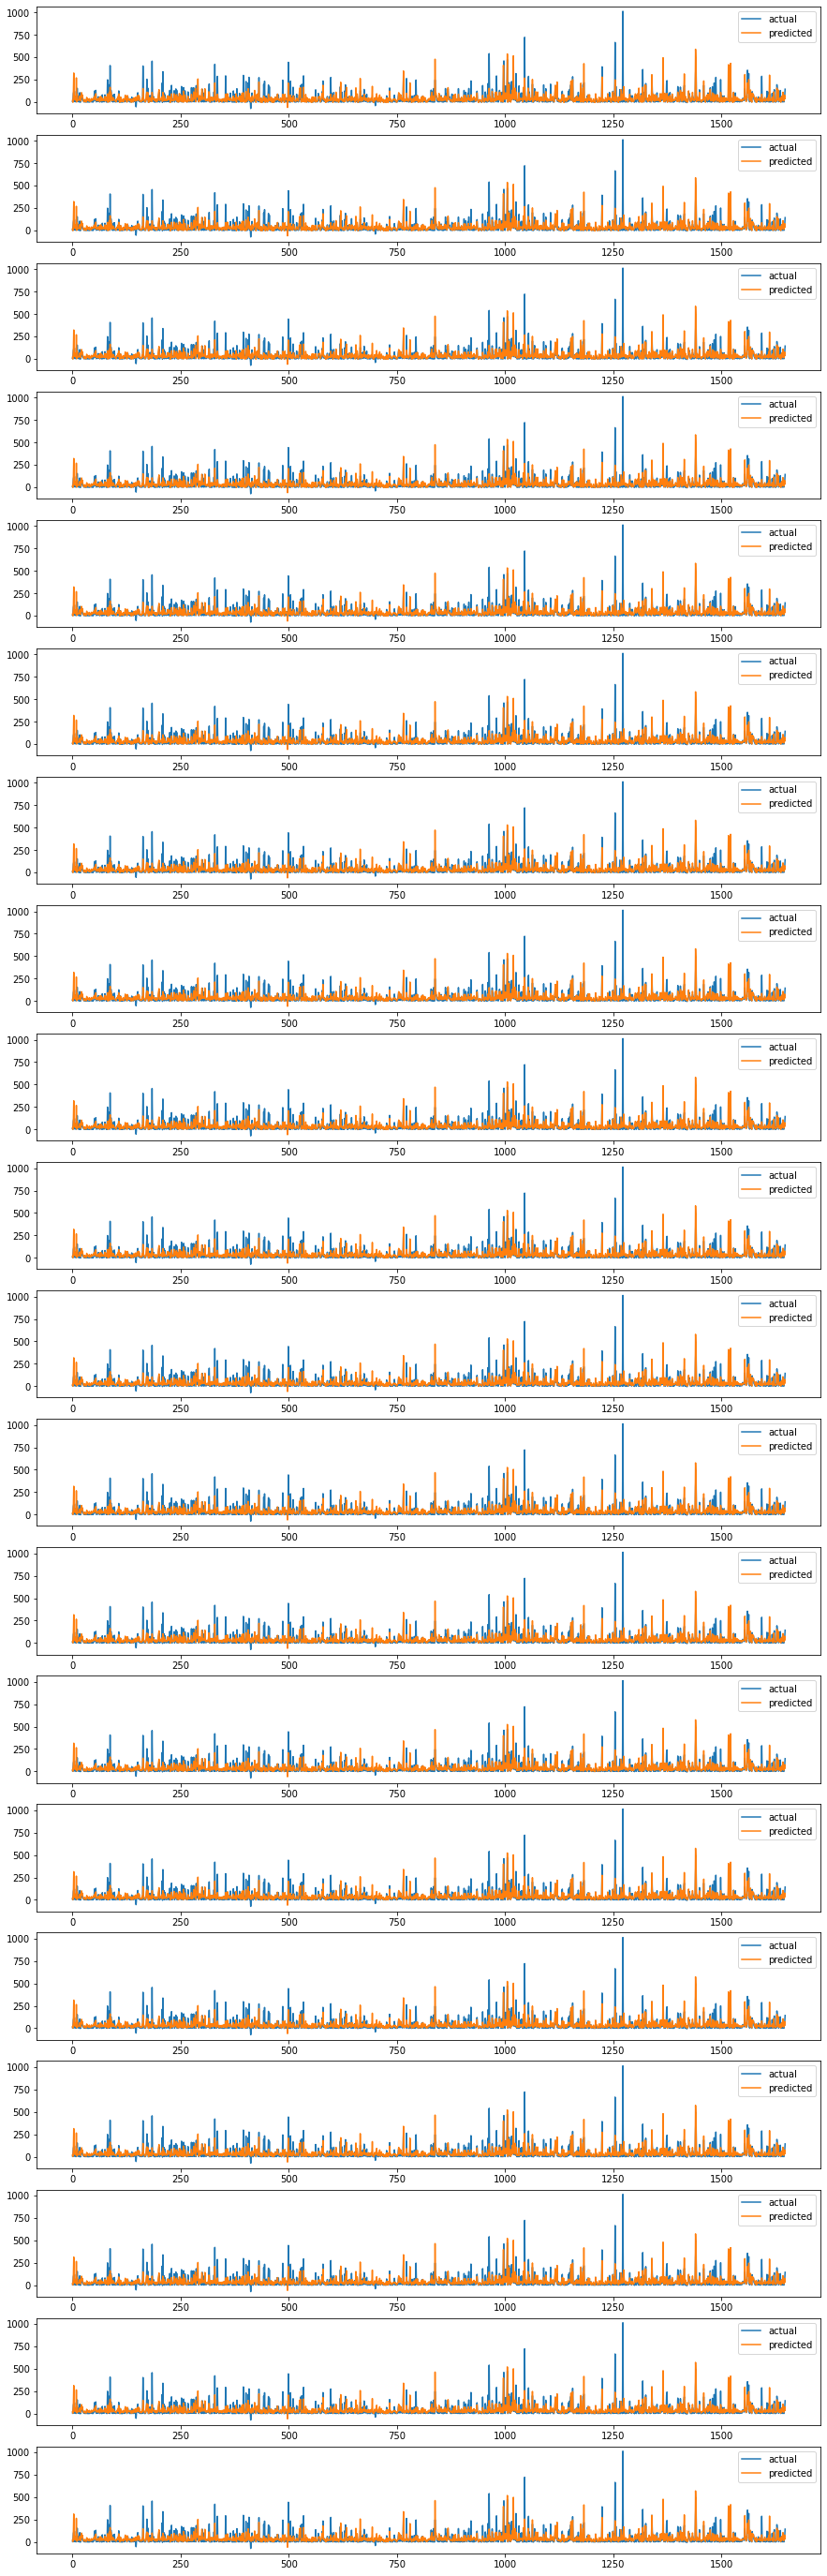

In [135]:
alphaValues = np.linspace(0.015, 0.07, 20)

start_l_t = time.time() # time how long it takes to find the model

# split the data into training and testing
(trainX, testX, trainY, testY) = train_test_split(X_w, Y_w, test_size = 0.4, random_state = 0)

trainMAE = []
testMAE = []

# allow multiple plots
fig, axes = plt.subplots(nrows = 20, figsize = (15,50))

for i in range(20):
  # create model
  model2i = linear_model.Lasso(alpha = alphaValues[i], normalize = True)

  # fit model
  model2i.fit(trainX, trainY)

  # test model
  trainPred = model2i.predict(trainX)
  testPred = model2i.predict(testX)
  trainMAE.append(mean_absolute_error(trainY,trainPred))
  testMAE.append(mean_absolute_error(testY,testPred))
  print("alpha = ", alphaValues[i])
  print('MSE-> train : %.3f, test : %.3f' % (mean_squared_error(trainY,trainPred), mean_squared_error(testY,testPred)))
  print('MAE-> train : %.3f, test : %.3f' % (mean_absolute_error(trainY,trainPred), mean_absolute_error(testY,testPred)))
  print('R2-> train : %.3f, test : %.3f' % (r2_score(trainY,trainPred), r2_score(testY,testPred)))
  print('     ')

  # plot model
  label = 'LASSO: tuning alpha = ' + str(np.round(alphaValues[i], 5))
  axes[i].plot(testY,label="actual")
  axes[i].plot(testPred, label="predicted")
  axes[i].legend()

end_l_t = time.time()
print('Tuning the LASSO models took', end_l_t - start_l_t, 'seconds')

Now, we will find the optimal $\alpha$ value from above.

In [136]:
min_train = 999
alpha_train = 0
min_test = 999
alpha_test = 0

for i in range(20):
  if min_train > trainMAE[i]:
    min_train = trainMAE[i]
    alpha_train = alphaValues[i]
  if min_test > testMAE[i]:
    min_test = testMAE[i]
    alpha_test = alphaValues[i]

print('training alpha:', alpha_train)
print('testing alpha:', alpha_test)

training alpha: 0.02368421052631579
testing alpha: 0.02947368421052632


We find that the optimal value of $\alpha$ for the training predicitons to be 0.0237, and for the testing predicitons to be 0.0295.

Now, we will tune the hyperparameter of the model with the individual models.

In [149]:
alphaValues = np.linspace(0.015, 0.07, 20)

trainMAE = []
testMAE = []

# iterate for each state
for i in range(10):
  start_l_t = time.time() # time how long it takes to find the model
  # create temporary dataset
  temp = DATA[DATA.state_index == unique_state_index_list[i]].to_numpy()

  # split data into X and Y components
  X = temp[:, 6:10]
  Y = temp[:, 10]

  # split the data into training and testing
  (trainX, testX, trainY, testY) = train_test_split(X, Y, test_size = 0.4, random_state = 0)

  min_train = 999
  alpha_train = 0
  min_test = 999
  alpha_test = 0

  print('State:', unique_state_name_list[i])

  for j in range(20):
    # create model
    model2j = linear_model.Lasso(alpha = alphaValues[j], normalize = True)

    # fit model
    model2j.fit(trainX, trainY)

    # test model
    trainPred = model2j.predict(trainX)
    testPred = model2j.predict(testX)
    trainMAE.append(mean_absolute_error(trainY,trainPred))
    testMAE.append(mean_absolute_error(testY,testPred))
    print('alpha = %.5f; R2-> train : %.3f, test : %.3f' % (alphaValues[j], r2_score(trainY,trainPred), r2_score(testY,testPred)))

    # check for min MAE
    if min_train > mean_absolute_error(trainY,trainPred):
      min_train = mean_absolute_error(trainY,trainPred)
      alpha_train = alphaValues[j]
    if min_test > mean_absolute_error(testY,testPred):
      min_test = mean_absolute_error(testY,testPred)
      alpha_test = alphaValues[j]

  end_l_t = time.time()
  print('Tuning the ridge models took', end_l_t - start_l_t, 'seconds')
  
  print('training alpha:', alpha_train)
  print('testing alpha:', alpha_test)
  print('----------------------------------------------------------------------------')

State: Washington
alpha = 0.01500; R2-> train : 0.154, test : 0.123
alpha = 0.01789; R2-> train : 0.154, test : 0.122
alpha = 0.02079; R2-> train : 0.154, test : 0.121
alpha = 0.02368; R2-> train : 0.154, test : 0.120
alpha = 0.02658; R2-> train : 0.154, test : 0.119
alpha = 0.02947; R2-> train : 0.153, test : 0.118
alpha = 0.03237; R2-> train : 0.153, test : 0.117
alpha = 0.03526; R2-> train : 0.153, test : 0.116
alpha = 0.03816; R2-> train : 0.153, test : 0.115
alpha = 0.04105; R2-> train : 0.152, test : 0.115
alpha = 0.04395; R2-> train : 0.152, test : 0.114
alpha = 0.04684; R2-> train : 0.151, test : 0.113
alpha = 0.04974; R2-> train : 0.151, test : 0.111
alpha = 0.05263; R2-> train : 0.150, test : 0.110
alpha = 0.05553; R2-> train : 0.150, test : 0.109
alpha = 0.05842; R2-> train : 0.149, test : 0.108
alpha = 0.06132; R2-> train : 0.149, test : 0.107
alpha = 0.06421; R2-> train : 0.148, test : 0.106
alpha = 0.06711; R2-> train : 0.148, test : 0.105
alpha = 0.07000; R2-> train : 0.

Now we will tune the elastic-net regression model, where we will tune the $\alpha$ and the L1-ratio parameters. For the sklearn implimentation of the Elastic-net regression model, the hyperparameters are $\alpha$ and L1-ratio, where $\alpha$ = a + b and L1-ratio = a / (a + b), and a * L1 + b * L2.

We tune the hyperparameters of the model first using the overall dataset.

In order to tune this model we will use the class "ElasticNetCV" from the sklearn package. Here, we will find the best hyperparameters of the elastic-net model by inputting lists of $\alpha$ values and L1-ratio values.

Tuning the elastic-net model took 1.18865966796875 seconds
MSE-> train : 4573.428, test : 3043.735
MAE-> train : 35.179, test : 30.805
R2-> train : 0.476, test : 0.436
alpha: 0.0014646597897974257
l1_ratio: 0.9


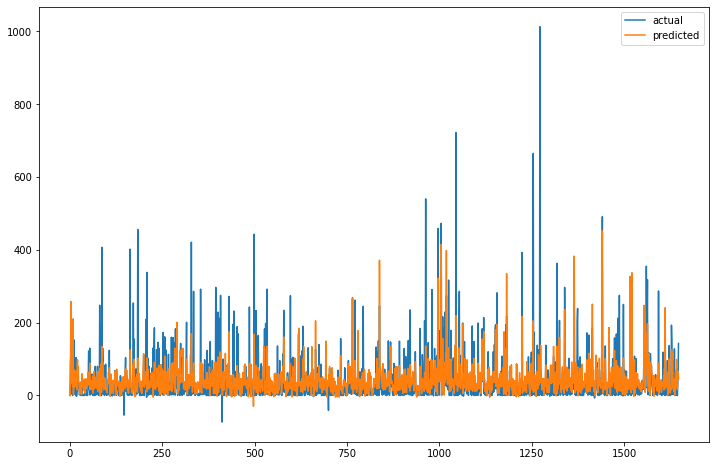

In [112]:
l1Values = np.linspace(0.8, 0.9, 20)

start_3 = time.time() # time how long it takes to find the model

# split the data into training and testing
(trainX, testX, trainY, testY) = train_test_split(X_w, Y_w, test_size = 0.4, random_state = 0)

trainMAE = []
testMAE = []

# create model
model3_t = linear_model.ElasticNetCV(l1_ratio = l1Values, normalize = True)
model3_t.fit(trainX, trainY)

end_3 = time.time()
print('Tuning the elastic-net model took', end_3 - start_3, 'seconds')

trainPred3e = model3_t.predict(trainX)
testPred3e = model3_t.predict(testX)
trainMAE.append(mean_absolute_error(trainY,trainPred3e))
testMAE.append(mean_absolute_error(testY,testPred3e))
print('MSE-> train : %.3f, test : %.3f' % (mean_squared_error(trainY,trainPred3e), mean_squared_error(testY,testPred3e)))
print('MAE-> train : %.3f, test : %.3f' % (mean_absolute_error(trainY,trainPred3e), mean_absolute_error(testY,testPred3e)))
print('R2-> train : %.3f, test : %.3f' % (r2_score(trainY,trainPred3e), r2_score(testY,testPred3e)))

# plot model
plt.figure(figsize=(12,8))
print('alpha:', model3_t.alpha_)
print('l1_ratio:', model3_t.l1_ratio_)
plt.plot(testY,label="actual")
plt.plot(testPred3e, label="predicted")
plt.legend()

From this, we find that the optimal $\alpha$ and L1-ratio values as 0.0015 and 0.9, respectively.

The L1-ratio value of 0.9 means that the elastic-net regression that works the best for the overall dataset is closer to LASSO regression (L1 regularization) than ridge regression (L2 regression).

Now, we will repeat this process for each individual state. 

state index = 52
state = Washington
alpha: 0.001301558013208716
l1_ratio: 0.26842105263157895
MSE-> train : 176.553, test : 329.205
MAE-> train : 9.091, test : 10.650
R2-> train : 0.150, test : 0.114
    
state index = 15
state = Illinois
alpha: 0.002655896761038532
l1_ratio: 0.9
MSE-> train : 1905.379, test : 1348.795
MAE-> train : 33.633, test : 28.458
R2-> train : 0.432, test : 0.473
    
state index = 5
state = California
alpha: 0.00752774377414438
l1_ratio: 0.9
MSE-> train : 15360.120, test : 14565.097
MAE-> train : 76.154, test : 76.529
R2-> train : 0.460, test : 0.491
    
state index = 3
state = Arizona
alpha: 0.0032029977652301405
l1_ratio: 0.8157894736842105
MSE-> train : 1894.170, test : 2478.732
MAE-> train : 26.475, test : 31.503
R2-> train : 0.426, test : 0.301
    
state index = 23
state = Massachusetts
alpha: 0.00149468910535688
l1_ratio: 0.8578947368421053
MSE-> train : 1389.474, test : 1353.889
MAE-> train : 26.466, test : 26.504
R2-> train : 0.271, test : 0.225
    


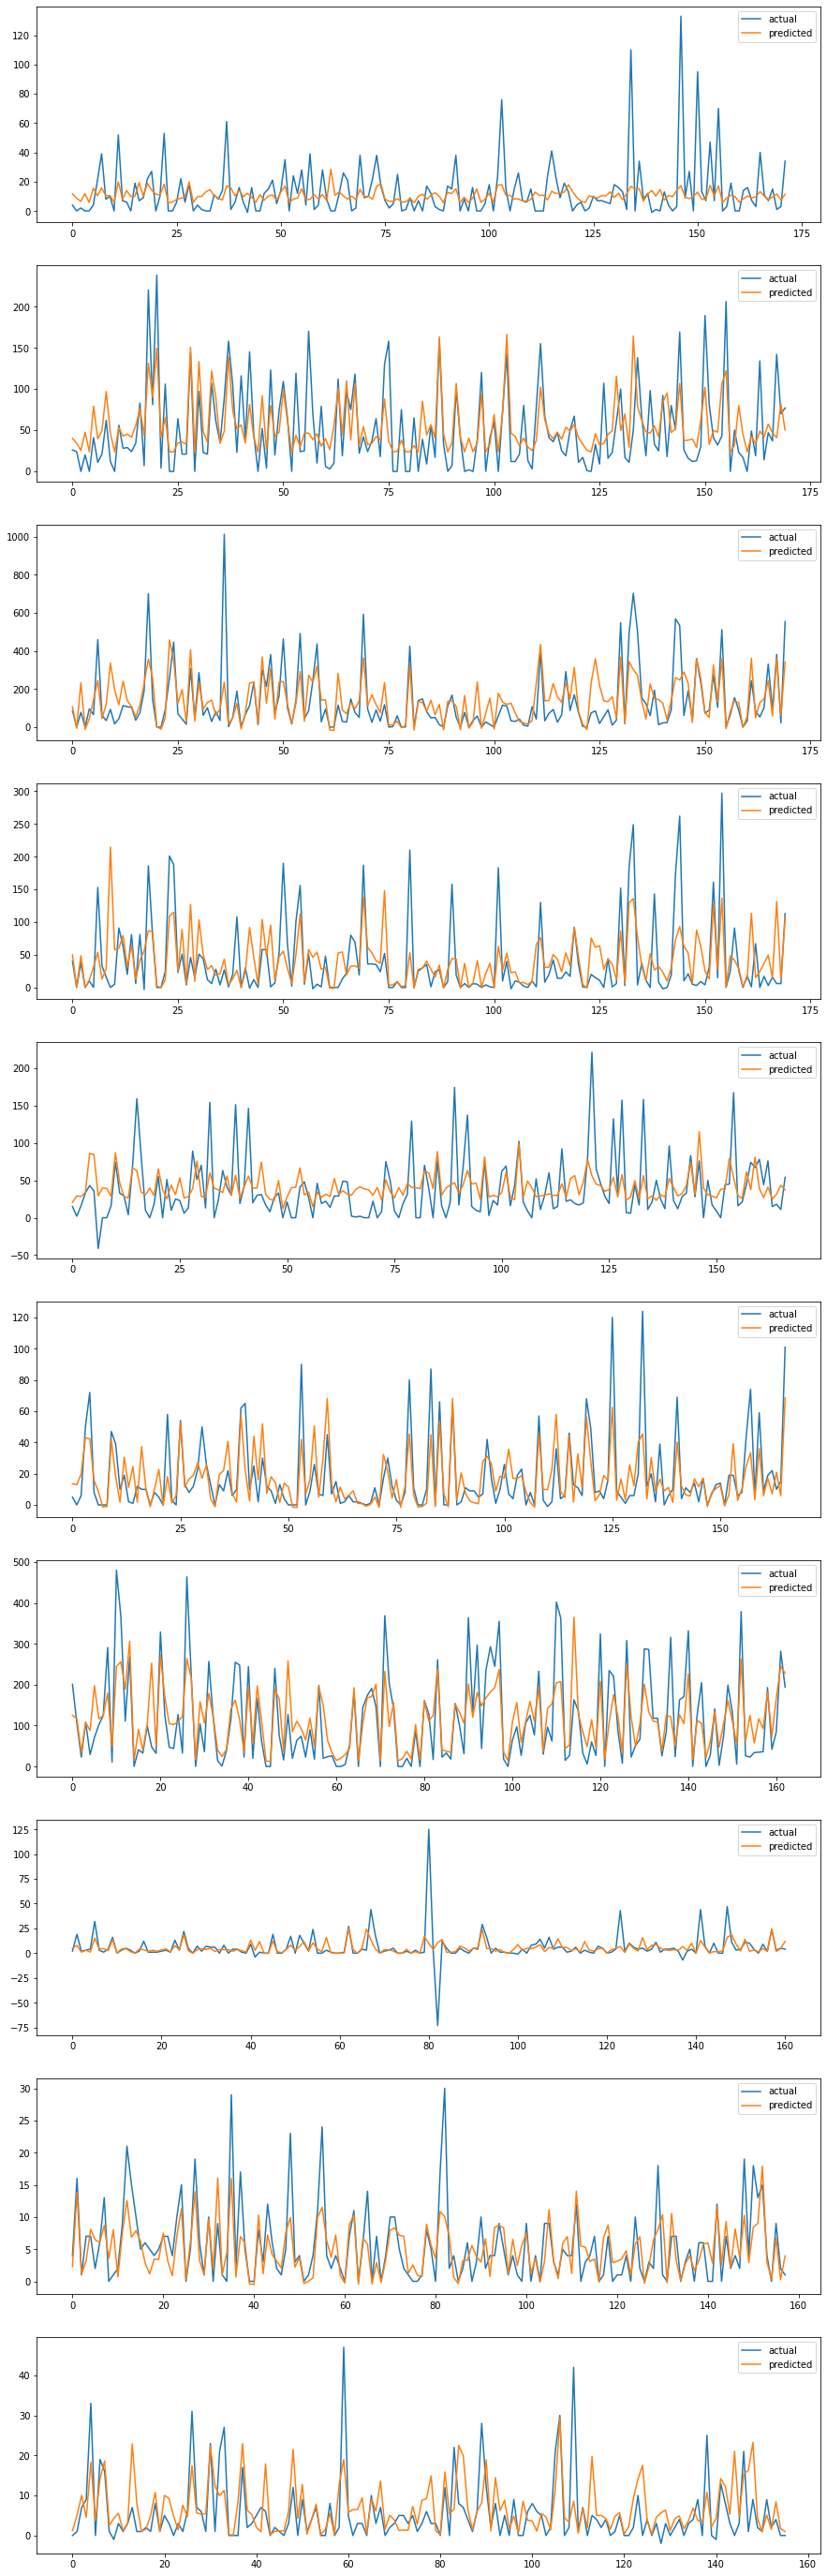

In [111]:
l1Values = np.linspace(0.1, 0.9, 20)

start_3 = time.time() # time how long it takes to find the model

# allow multiple plots
fig, axes = plt.subplots(nrows = 10, figsize = (15,50))

for i in range(10):
  # create temporary dataset
  temp = DATA[DATA.state_index == unique_state_index_list[i]].to_numpy()

  # split data into X and Y components
  X = temp[:, 6:10]
  Y = temp[:, 10]

  # split the data into training and testing
  (trainX, testX, trainY, testY) = train_test_split(X, Y, test_size = 0.4, random_state = 0)

  # create model
  model3_r_i = linear_model.ElasticNetCV(l1_ratio = l1Values, normalize = True)
  model3_r_i.fit(trainX, trainY)

  trainPred3e = model3_r_i.predict(trainX)
  testPred3e = model3_r_i.predict(testX)
  print('state index =', unique_state_index_list[i])
  print('state =', unique_state_name_list[i])
  print('alpha:', model3_r_i.alpha_)
  print('l1_ratio:', model3_r_i.l1_ratio_)
  print('MSE-> train : %.3f, test : %.3f' % (mean_squared_error(trainY,trainPred3e), mean_squared_error(testY,testPred3e)))
  print('MAE-> train : %.3f, test : %.3f' % (mean_absolute_error(trainY,trainPred3e), mean_absolute_error(testY,testPred3e)))
  print('R2-> train : %.3f, test : %.3f' % (r2_score(trainY,trainPred3e), r2_score(testY,testPred3e)))
  print('    ')

  # plot model
  axes[i].plot(testY,label="actual")
  axes[i].plot(testPred3e, label="predicted")
  axes[i].legend()

end_3 = time.time()
print('Tuning the elastic-net models took', end_3 - start_3, 'seconds')

# Conclusions

It can be seen from the previous sections that the models will either give a better $R^2$ score or a better MAE. 

For the overall dataset, the model that gave the best $R^2$ score was the ridge regression model, whereas the the model that gave the best MAE value was the LASSO regression model.

LASSO took 0.007172346115112305 seconds
MSE-> train : 4314.712, test : 3029.058
MAE-> train : 32.088, test : 28.277
R2-> train : 0.506, test : 0.439


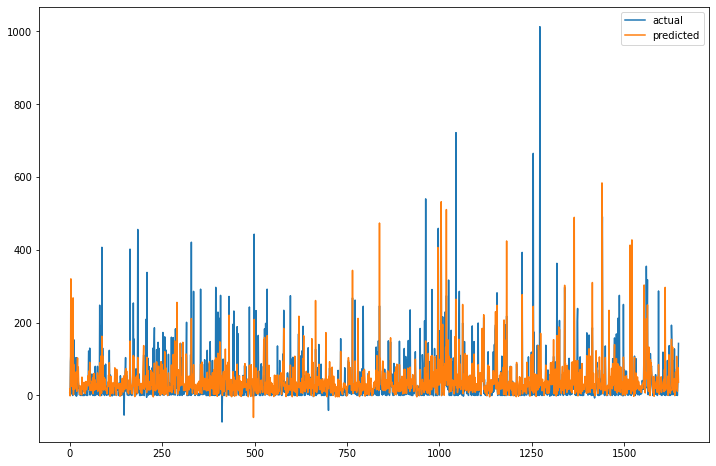

In [150]:
start_2_l = time.time() # time how long it takes to find the model

# split the data into training and testing
(trainX, testX, trainY, testY) = train_test_split(X_w, Y_w, test_size = 0.4, random_state = 0)

# create model
model_l = linear_model.Lasso(alpha = 0.02947368421052632, normalize = True)

# fit model
model_l.fit(trainX, trainY)

end_2_l = time.time()
print('LASSO took', end_2_l - start_2_l, 'seconds')

# test model
trainPred2 = model_l.predict(trainX)
testPred2 = model_l.predict(testX)
print('MSE-> train : %.3f, test : %.3f' % (mean_squared_error(trainY,trainPred2), mean_squared_error(testY,testPred2)))
print('MAE-> train : %.3f, test : %.3f' % (mean_absolute_error(trainY,trainPred2), mean_absolute_error(testY,testPred2)) )
print('R2-> train : %.3f, test : %.3f' % (r2_score(trainY,trainPred2), r2_score(testY,testPred2)))

plt.figure(figsize=(12,8))
plt.plot(testY,label="actual")
plt.plot(testPred2, label="predicted")
plt.legend()
plt.show()

Now, we will use this model to test on the extra state data.

LASSO took 0.0017659664154052734 seconds
MAE-> test : 36.488
R2-> test : 0.391


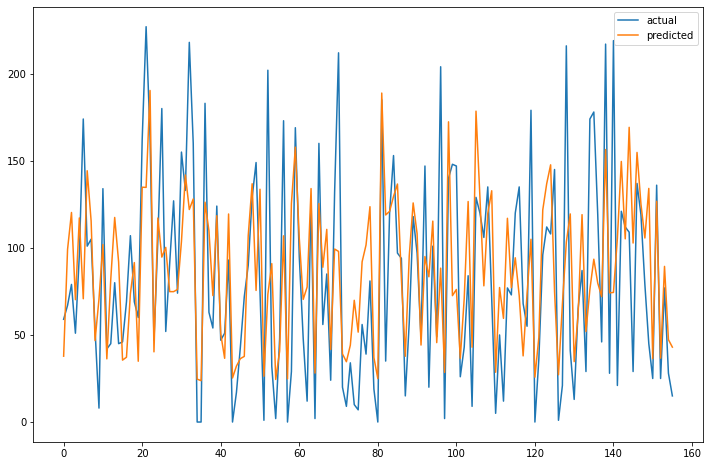

In [152]:
start_2_l = time.time() # time how long it takes to find the model

# split new state into X and Y
X_extra = state_10[:, 6:10]
Y_extra = state_10[:, 10]

# split the data into training and testing
(trainX, testX, trainY, testY) = train_test_split(X_extra, Y_extra, test_size = 0.4, random_state = 0)
# split the data into training and testing
(trainX, testX, trainY, testY) = train_test_split(X_w, Y_w, test_size = 0.4, random_state = 0)

# create model
model_l = linear_model.Lasso(alpha = 0.02947368421052632, normalize = True)

# fit model
model_l.fit(trainX, trainY)

end_2_l = time.time()
print('LASSO took', end_2_l - start_2_l, 'seconds')

# test model
trainPred2 = model_l.predict(trainX)
testPred2 = model_l.predict(testX)
print('MAE-> test : %.3f' % (mean_absolute_error(testY,testPred2)))
print('R2-> test : %.3f' % (r2_score(testY,testPred2)))

plt.figure(figsize=(12,8))
plt.plot(testY,label="actual")
plt.plot(testPred2, label="predicted")
plt.legend()
plt.show()

It can be seen that this model predicts the new state with an $R^2$ score and the MAE at about 0.39 and about 37, respectively. 

Now, we will use the model trained with the entrie dataset to make predictions about the new set. 

LASSO took 0.0028481483459472656 seconds
MAE-> test : 39.383
R2-> test : 0.289


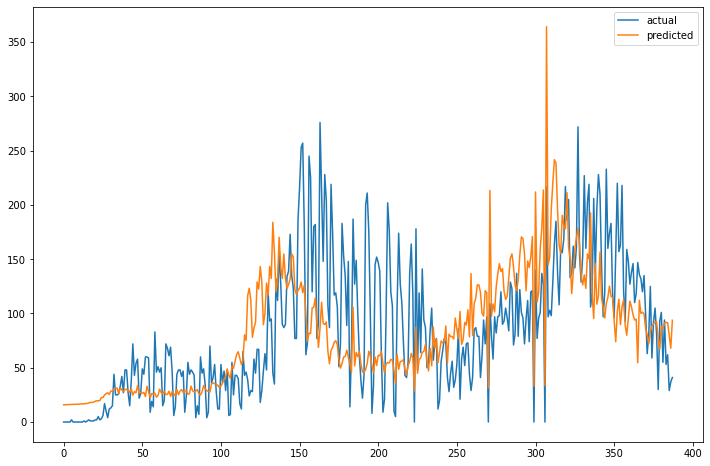

In [155]:
start_2_l = time.time() # time how long it takes to find the model

# split new state into X and Y
X_extra = state_10[:, 6:10]
Y_extra = state_10[:, 10]

# split the data into training and testing
(trainX, testX, trainY, testY) = train_test_split(X_w, Y_w, test_size = 0.4, random_state = 0)

# create model
model_l = linear_model.Lasso(alpha = 0.02947368421052632, normalize = True)

# fit model
model_l.fit(trainX, trainY)

end_2_l = time.time()
print('LASSO took', end_2_l - start_2_l, 'seconds')

# test model
testPred2 = model_l.predict(X_extra)
print('MAE-> test : %.3f' % (mean_absolute_error(Y_extra,testPred2)))
print('R2-> test : %.3f' % (r2_score(Y_extra,testPred2)))

plt.figure(figsize=(12,8))
plt.plot(Y_extra,label="actual")
plt.plot(testPred2, label="predicted")
plt.legend()
plt.show()

It can be seen for this model that while the prediciton criteria are not good, this model produces predicted values that have some displacement to the left. 

For each of the individual states, different models produced better results for each of the states. The ridge regression model was better for Washington, Massachusetts, Wisconsin and Utah. The LASSO regression model was better for Illinois, Texas and Oregon. The elastic-net regression model was better for California, Arizona and Nebraska.